# NATRE region variance budget

Reproducing the Ferrari & Polzin (2005) estimate using NATRE data, and comparing differences with our version

In [1]:
%load_ext watermark
%matplotlib inline

import glob

import cf_xarray as cfxr
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
import xarray as xr
import xgcm
from IPython.display import Image

import eddydiff as ed

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200
plt.style.use("ggplot")


%watermark -iv
xr.DataArray([1.0])

dcpy       : 0.1
distributed: 2021.11.2
xarray     : 0.20.2.dev24+gf08672847
xgcm       : 0.6.0
cf_xarray  : 0.6.1
matplotlib : 3.5.0
scipy      : 1.7.3
tqdm       : 4.62.3
numpy      : 1.20.3
eddydiff   : 0.1



<xarray.DataArray (dim_0: 1)>
array([1.])
Dimensions without coordinates: dim_0

In [8]:
if "client" in locals():
    client.cluster.close()
    client.close()
client = distributed.Client(n_workers=2, threads_per_worker=2)
client

<Client: 'tcp://127.0.0.1:44069' processes=2 threads=4, memory=31.09 GiB>

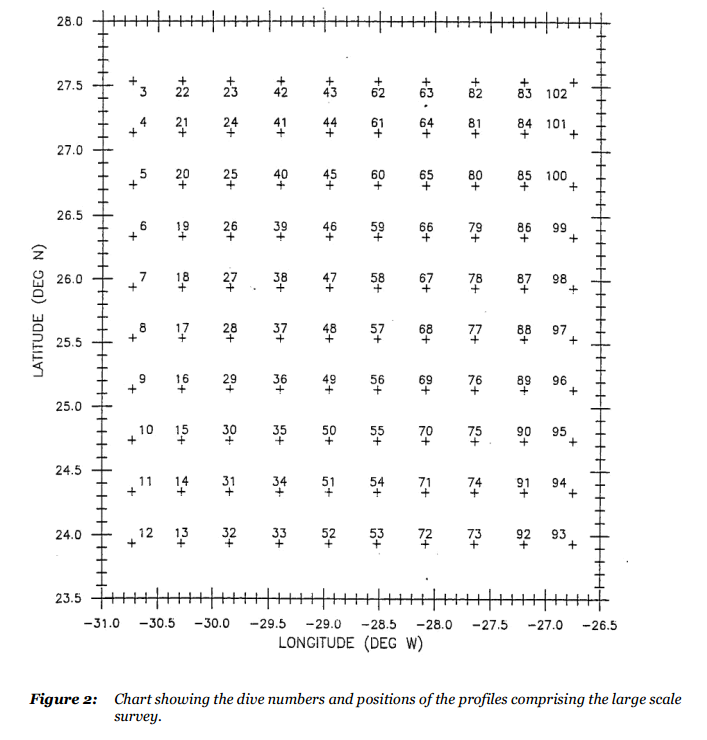

In [3]:
Image("../images/natre-large-scale.png")

## Prepare various production and dissipation terms

In theory, these bins are approx. 100m apart in neutral density

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

<xarray.Dataset>
Dimensions:             (gamma_n: 17, bound: 2)
Coordinates:
  * gamma_n             (gamma_n) float64 26.79 26.96 27.1 ... 27.93 27.95 27.96
  * bound               (bound) <U5 'lower' 'upper'
    num_obs             (gamma_n) int64 19763 19424 17093 ... 18916 21881 10032
    pres                (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    reference_pressure  int64 1000
    gamma_n_bounds      (bound, gamma_n) float64 26.69 26.88 ... 27.96 27.97
Data variables: (12/28)
    chi                 (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    eps                 (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    hm                  (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dTdz_m              (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    N2_m                (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Krho_m              (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                  ...
    δKt_m               (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    δwTTz               (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    δresidual           (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    δpres               (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    chib2               (gamma_n) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    chib2_err           (gamma_n, bound) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/13)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               North Atlantic Tracer Release Experiment (NATRE)
    expocode:              32OC250_4
    cast_number:           3.0
    title:                 Microstructure profiler data from the ship Oceanus...
    ...                    ...
    latitude:              27.533166666666666
    longitude:             -30.723333333333333
    chief_scientist:       Raymond W. Schmitt
    data_originator:       Polzin
    institution:           WHOI
    data_assembly_center:  CCHDO

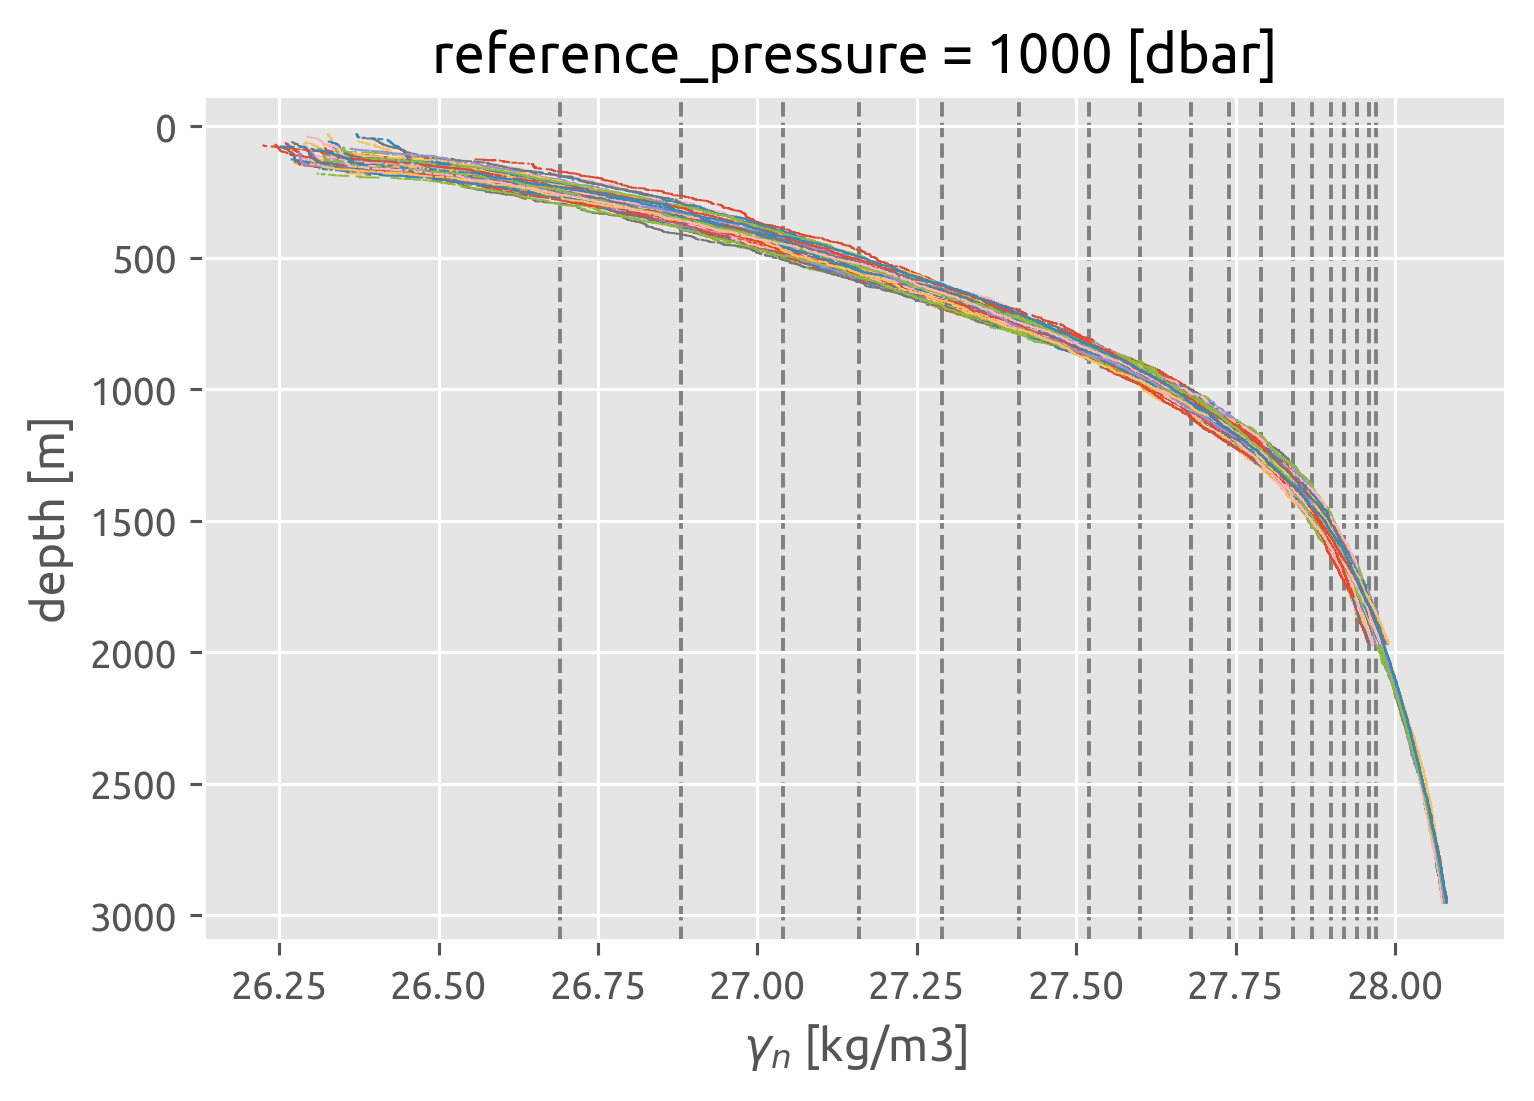

In [65]:
#natre = ed.natre.read_natre().load()
bins = ed.sections.choose_bins(natre.gamma_n, depth_range=np.arange(150, 2001, 100))
natre.gamma_n.stack({"latlon": ["latitude", "longitude"]}).drop("latlon").cf.plot(
    hue="latlon",
    y="depth",
    lw=0.5,
    add_legend=False,
    yincrease=False,
)
dcpy.plots.linex(bins)

micro = ed.sections.bin_average_vertical(
    natre.reset_coords("pres"), "neutral_density", bins
)
micro

In [66]:
micro.load(scheduler=client).to_netcdf("../datasets/natre-density-binned.nc")

In [67]:
micro = xr.load_dataset("../datasets/natre-density-binned.nc")

In [4]:
natre_fine = xr.load_dataset("../datasets/natre-finescale.nc")
natre_fine_avg = (
    natre_fine.groupby_bins("pressure", bins=np.arange(250, 2001, 200))
    .mean()
    .cf.guess_coord_axis()
)
natre_fine_avg.pressure_bins.attrs = {
    "positive": "down",
    "standard_name": "sea_water_pressure",
}

In [26]:
argo_fine_profiles = xr.load_dataset(
    "../datasets/argomix_natre.zarr", engine="zarr"
).drop("DIRECTION")
argo_fine_profiles["Kt"] = argo_fine_profiles["Kρ"]
argo_fine_profiles["Kt"].attrs["long_name"] = "$K_T$"
# argo_fine_profiles = argo_fine_profiles.where(argo_fine_profiles.ε < 0.1)
bins = cfxr.bounds_to_vertices(micro.gamma_n_bounds, "bound").data
argo_fine_dens = (
    argo_fine_profiles.rename({"γmean": "gamma_n"})
    .reset_coords("pressure")
    .groupby_bins("gamma_n", bins=bins)
    .mean()
)
argo_fine_dens["gamma_n_bins"].attrs = {
    "standard_name": "neutral_density",
    "axis": "Z",
    "positive": "down",
}
argo_fine_dens["npts"] = (
    argo_fine_profiles.χ.rename({"γmean": "gamma_n"})
    .groupby_bins("gamma_n", bins=bins)
    .count()
)
argo_fine_dens = argo_fine_dens.set_coords("pressure")

argo_fine_depth = argo_fine_profiles.groupby_bins(
    "pressure", np.arange(250, 2050, 200)
).mean()
argo_fine_depth["pressure_bins"].attrs = {"standard_name": "sea_water_pressure"}

In [25]:
pop_natre = xr.load_dataset("../datasets/natre-pop-variance.nc")

This uses a crappier gradient.

In [24]:
cole = ed.read_cole()

# read, take mean in region; swap to pressure coordinate
argograd = (
    xr.open_dataset("../datasets/cole-clim-gradient-natre.nc")
    .reset_coords("pres")
    .sel(lat=slice(24, 28), lon=slice(360 - 30, 360 - 25))
)

cole_natre = cole[["diffusivity", "density_mean_depth", "depth_mean_sig"]].interp(
    lat=argograd.lat.data, lon=argograd.lon.data
)

# move from sigma to depth space
argo_dTiso = xgcm.transform.linear_interpolation(
    argograd.dTiso,
    argograd.pres,
    cole.pres,
    "sigma",
    "sigma",
    "pres",
)

cole_var = (cole_natre.diffusivity * argo_dTiso ** 2).mean(["lat", "lon"])
cole_var["pres"] = cole_natre["pres"]
cole_var.attrs = {"long_name": "$K_e^{cole} |∇T_{iso}^{argo}|²$", "units": "°C²/s"}

groeskamp = (
    xr.open_dataset("/home/deepak/datasets/groeskamp2020/groeskamp2020.nc")
    .sel(lat=slice(24, 28), lon=slice(360 - 30, 360 - 25))
    .rename({"depth": "pres"})
)
groeskamp["dTiso"] = argo_dTiso.interp(pres=groeskamp.pres)
groeskamp["eddy_var_0"] = groeskamp["Ke_0"] * groeskamp.dTiso ** 2
groeskamp["eddy_var"] = groeskamp["Ke"] * groeskamp.dTiso ** 2
groeskamp = groeskamp.mean(["lat", "lon"])

## Variance production vs dissipation

1. Agreement between POP "mesoscale variance dissipation" and microstructure estimate of "variance received from mesoscale" is great! (Purple dashed steps agree well with purple solid line)
1. POP's grid-scale temp variance dissipation is really dominated by the horizontal biharmonic diffusion, but fundamentally the amount of mesoscale variance destroyed by grid-scale diffusion matches that in the microstructure measurements.
1. Cole/Groeskamp $K_e$ estimate based variance dissipation compares much better now.
    1. ~Comparing to variance dissipated by parameterizations for $K_e$ ($K_e |∇_hT|²$) doesn't work well. I wonder if I'm doing something wrong with my $∇_hT$ estimate~
    1. I updated my |∇T| estimation code; now estimate along-isopycnal gradients in σ space instead of just a lateral gradient
    1. While the current algo still doesn't match Silvia's ∇S (but much better than earlier), it seems to improve agreement (panel c)

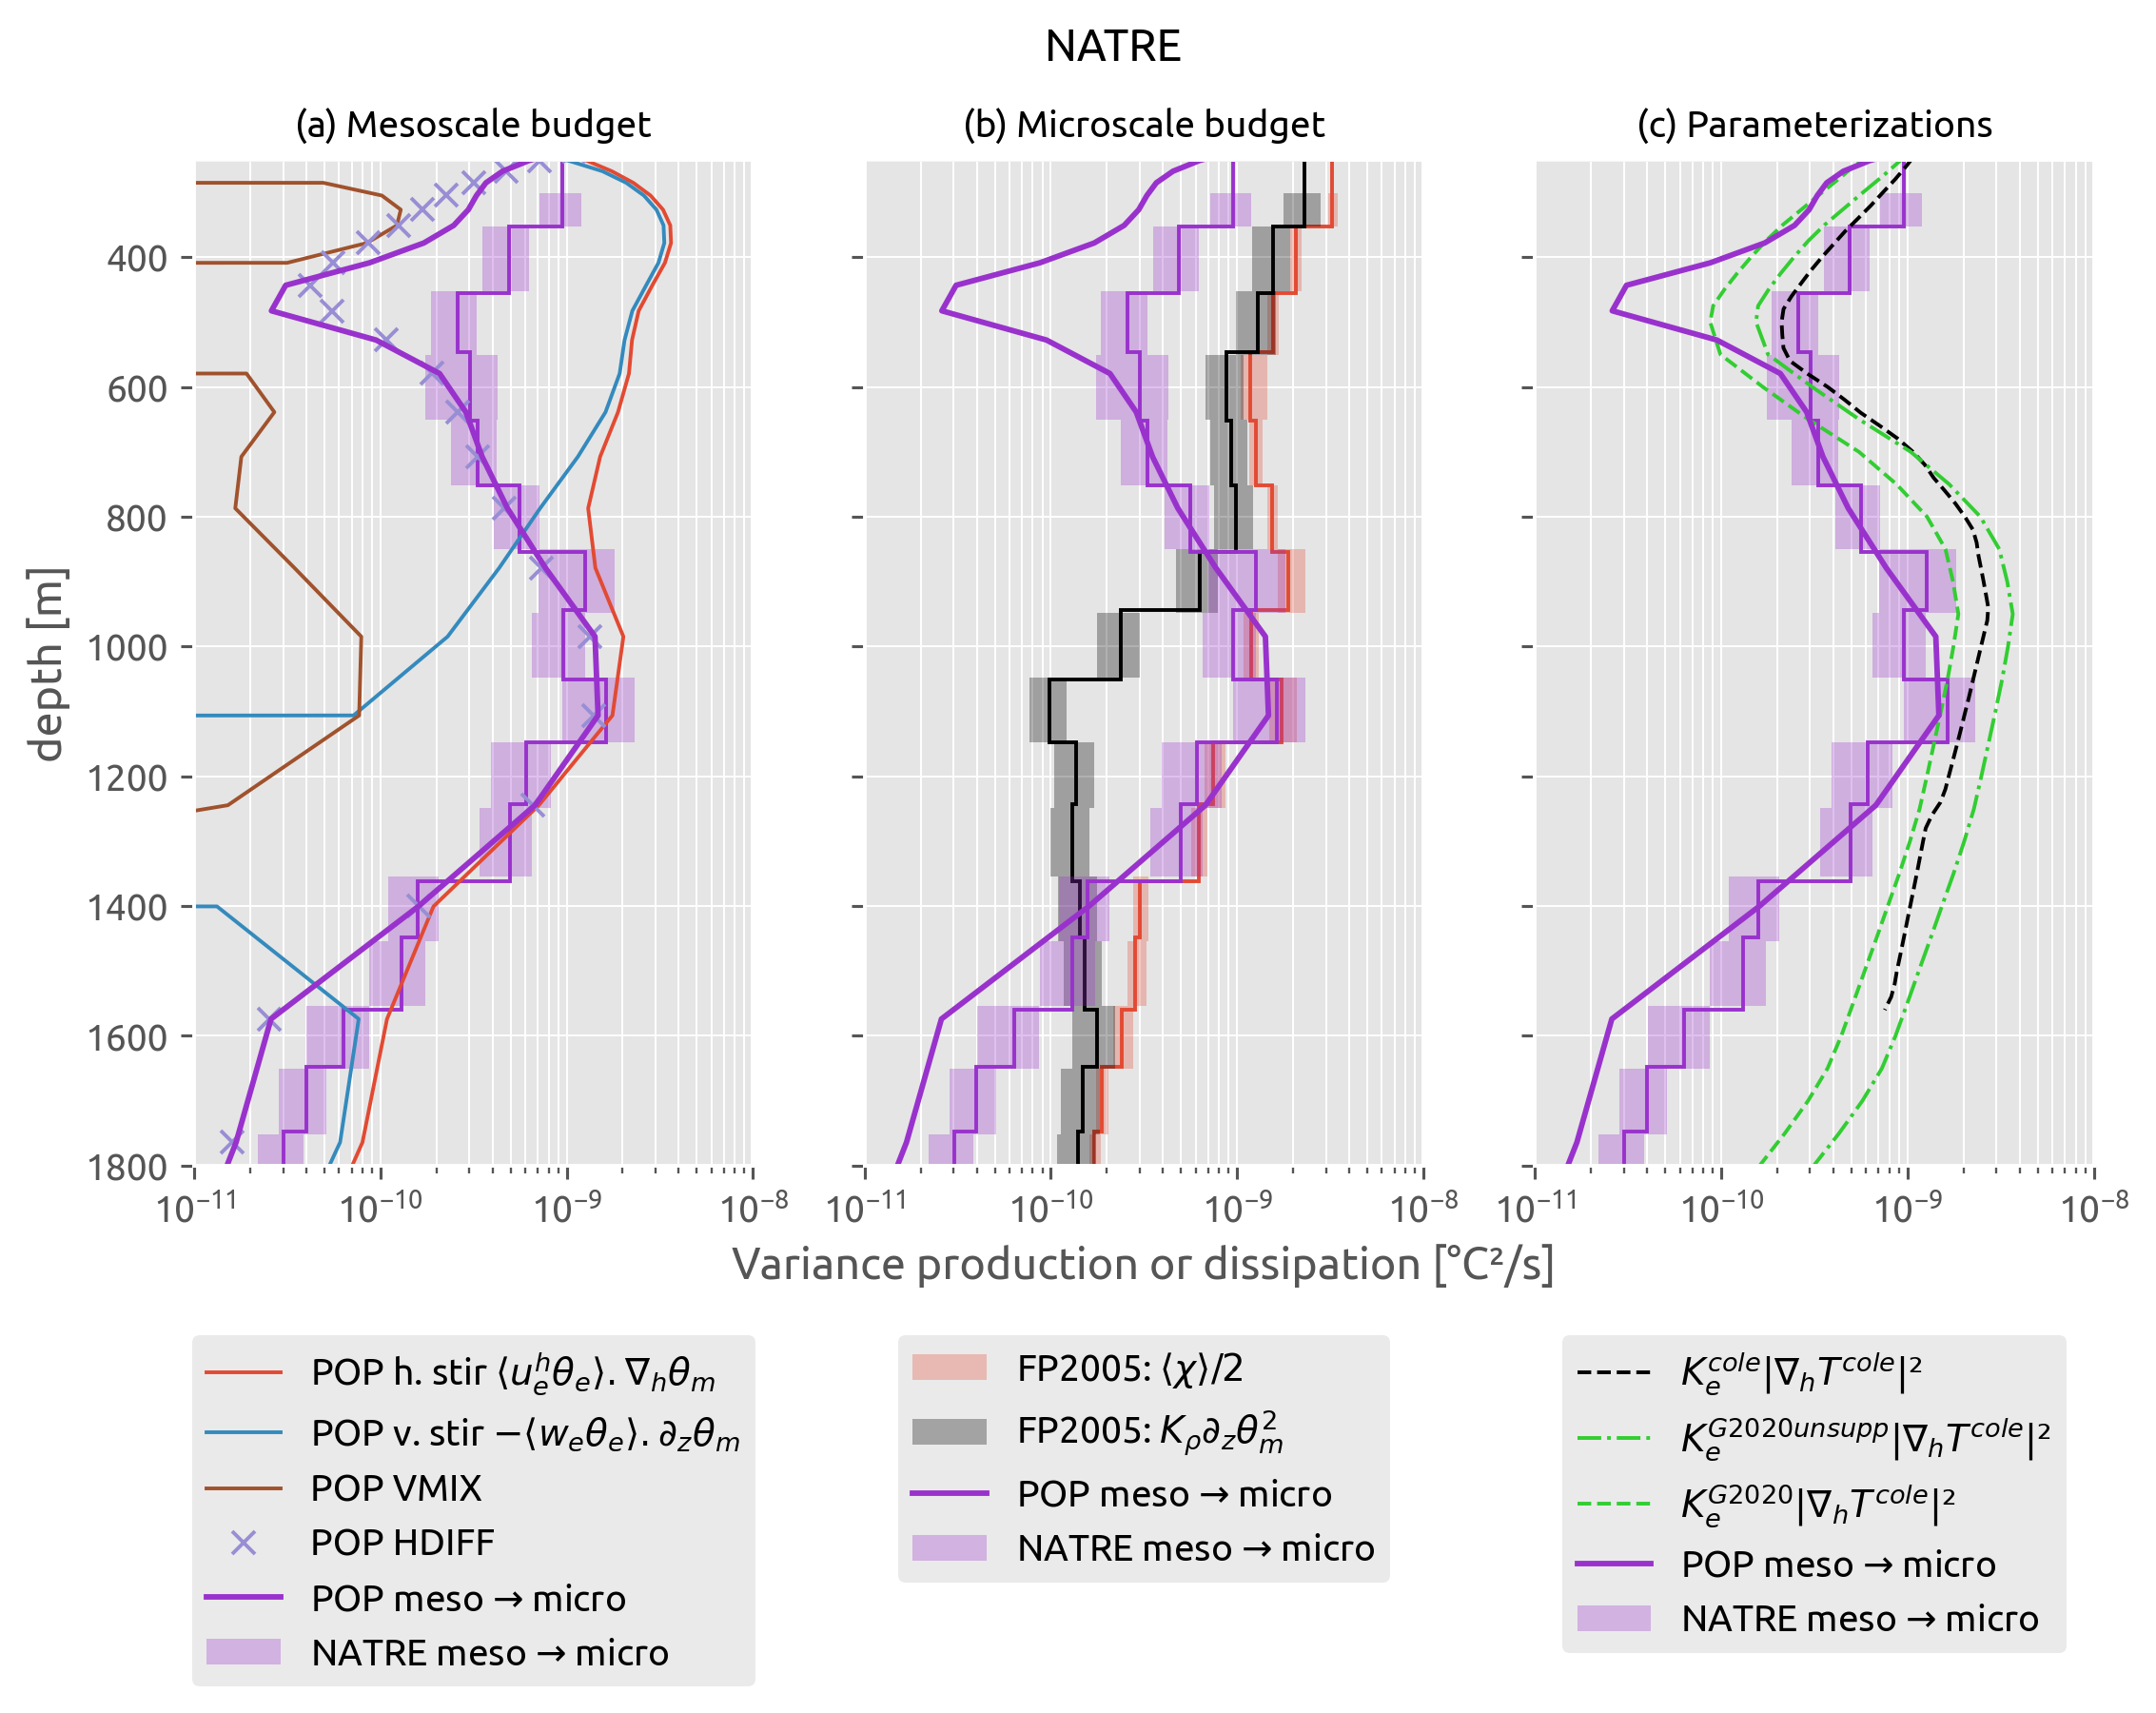

In [115]:
def plot_pop_natre_meso_micro(ax):
    mesomicrocolor = "darkorchid"
    (-1 * pop_natre.DISS).cf.plot(
        ax=ax, lw=1.5, color=mesomicrocolor, label="POP meso $→$ micro"
    )

    dcpy.plots.fill_between_bounds(
        micro,
        "residual",
        y="pres",
        color=mesomicrocolor,
        label="NATRE meso $→$ micro",
        ax=ax,
    )
    

f, ax = plt.subplots(1, 3, sharey=True, sharex=True, constrained_layout=False)

### Mesoscale budget
pop_natre.BC.cf.plot(ax=ax[0], label="POP h. stir $⟨u_e^h θ_e⟩.∇_hθ_m$")
(-1 * pop_natre.PKC).cf.plot(ax=ax[0], label="POP v. stir $-⟨w_eθ_e⟩.∂_zθ_m$")
(-1 * pop_natre.VMIX).cf.plot(color="sienna", ax=ax[0], label="POP VMIX")
(-1 * pop_natre.HDIFF).cf.plot(ax=ax[0], label="POP HDIFF", marker="x", ls="none")


### Microscale budget
plt.sca(ax[1])

dcpy.plots.fill_between_bounds(
    micro, "chib2", y="pres", color="C0", label="FP2005: $⟨χ⟩/2$"
)
dcpy.plots.fill_between_bounds(
    micro, "wTTz", y="pres", color="k", label="FP2005: $K_ρ  ∂_zθ_m^2$"
)

# (micro.chi / 2).cf.plot.step(
#    y="pres",
#    color="r",
#    lw=2,
#    xlim=(1e-11, 1e-8),
#    ylim=(1800, 200),
# )
# (micro.Krho_m * micro.dTdz_m ** 2).cf.plot.step(
#    color="k",
#    lw=2,
#    y="pres",
# )
# (argo_fine_depth.χ.sel(criteria="whalen") / 2).cf.plot.step(
#    marker="o",
#    color="C1",
#    ax=plt.gca(),
#    y="pressure_bins",
#    label="$⟨χ⟩^{argo}_{Rω=3}/2$",
# )

### Parameterizations
cole_var.plot(
    y="pres", label="$K_e^{cole} |∇_hT^{cole}|²$", color="k", ls="--", ax=ax[2]
)
groeskamp.eddy_var_0.plot(
    y="pres",
    label="$K_e^{G2020unsupp} |∇_hT^{cole}|²$",
    color="limegreen",
    ls="-.",
    ax=ax[2],
)
groeskamp.eddy_var.plot(
    y="pres", label="$K_e^{G2020} |∇_hT^{cole}|²$", color="limegreen", ls="--", ax=ax[2]
)

### Cleanup
for axx in ax:
    plot_pop_natre_meso_micro(axx)
    axx.set_xscale("log")
    axx.set_xlabel("")
    axx.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15))
    axx.grid(True, which="both", lw=0.5)
ax[1].set_xlabel("Variance production or dissipation [°C²/s]")

f.suptitle("NATRE")
ax[0].set_title("(a) Mesoscale budget", fontsize="medium")
ax[1].set_title("(b) Microscale budget", fontsize="medium")
ax[2].set_title("(c) Parameterizations", fontsize="medium")

ax[0].set_xlim([1e-11, 1e-8])
ax[0].set_ylim([1800, 250])

dcpy.plots.clean_axes(ax)
f.set_size_inches((9.2, 5))
#f.savefig("../images/natre-meso-micro-param.png")

### Interpretation

#### Spicy region

We can interpret the red mesoscale dissipation term in (b) as the amount of variance transferred to the microscale for eventual dissipation. This peaks in regions of high mean spice between 1000m and 1500m. The balance in spicy regions is that horizontal mesoscale stirring converts MPE → EPE (compensated filaments or T-S variance) that is dissipated by the microscale. The approximate budget is (note vertical stirring gets ignored, and $u^h$ represents horizontal velocity vector)
\begin{align}
⟨u^h_eT_e⟩ ⋅ ∇_hT_m - ⟨\widetilde{u_t T_t} ⋅ ∇T_e⟩ &\approx 0 \\
⟨\widetilde{u_t T_t} ⋅ ∇ T_e⟩ &\approx - \frac 12 ⟨χ⟩
\end{align}
1. Yiming sees the first equation as "lateral stirring" balances "mesoscale dissipation", and 
2. FP2005 combine the two equations to conclude that "mesoscale stirring of mean variance" balances "total microscale dissipation"


#### Weak spice
In the upper water column that is not spicy, we instead see horizontal stirring MPE→ EPE which is then routed to EKE by "vertical stirring". Here the scale transformation term is 0 so the budget is
\begin{align}
⟨u_eT_e⟩ ⋅ ∇T_m &\approx 0 \\
⟨u_tT_t⟩ ⋅ ∇ T_m &\approx - \frac 12 ⟨χ⟩
\end{align}
1. Yiming sees the first equation as "low dissipation" or "lateral stirring balances vertical stirring"; 
2. FP2005 sees the second equation as "microscale stirring of the mean" balances "total microscale dissipation"


### Next steps:

1. [ ] Microscale variance budget
    1. Could estimate  $⟨u_t T_t⟩ ⋅ ∇T_m = -⟨K_t  T_z⟩ T_z^m$ term (monthly mean heat flux X monthly mean vertical gradient) using the model; just like I do with  the microstructure data.
    1. Then add the mesoscale dissipation term to get total $⟨χ⟩$
    
2. [x] Put observation, model, parameterization estimates on same figure; Add Cole / Groeskamp estimate of $K_e |∇T_m|^2$ 


## All microscale budget terms


**Microscale budget:**
- Ferrari & Polzin use $⟨u_t θ_t⟩.∇θ_m = -Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$, we are instead doing $-⟨K_T θ_z⟩ ∂_zθ_m$. 
- Our estimate mostly agrees with theirs (crosses versus solid-line-steps). 
  1. Filling in NaNs in the temperature profiles was important. This means more estimates are used in the averages
  2. Masked where both $χ$ and $ε$ are both available.
  3. Masked so that $|θ_z|$ > 1e-3 (really important, otherwise our estimate is too high)

**Variance produced by parameterizations for eddy diffusivity:**
- The comparison with variance production using Cole et al diffusivity and gradients calculated in a similar way disagree significantly between 400 and 1000m. Below that there's not much data but it seems to agree.
- The Groeskamp et al (2020) estimate [G2020] is slightly better but not by much. All predict a maximum in variance production near 800m

**⟨χ⟩ estimate using finescale parameterizations:**
- The finescale estimates are interesting, argo with Rω=3 and natre with Rω=7 work well but why? 
- There is some interesting discrepancy here. This choice of $Rω$ makes for a factor of 2 difference which would hide the mesoscale→microscale transformation.

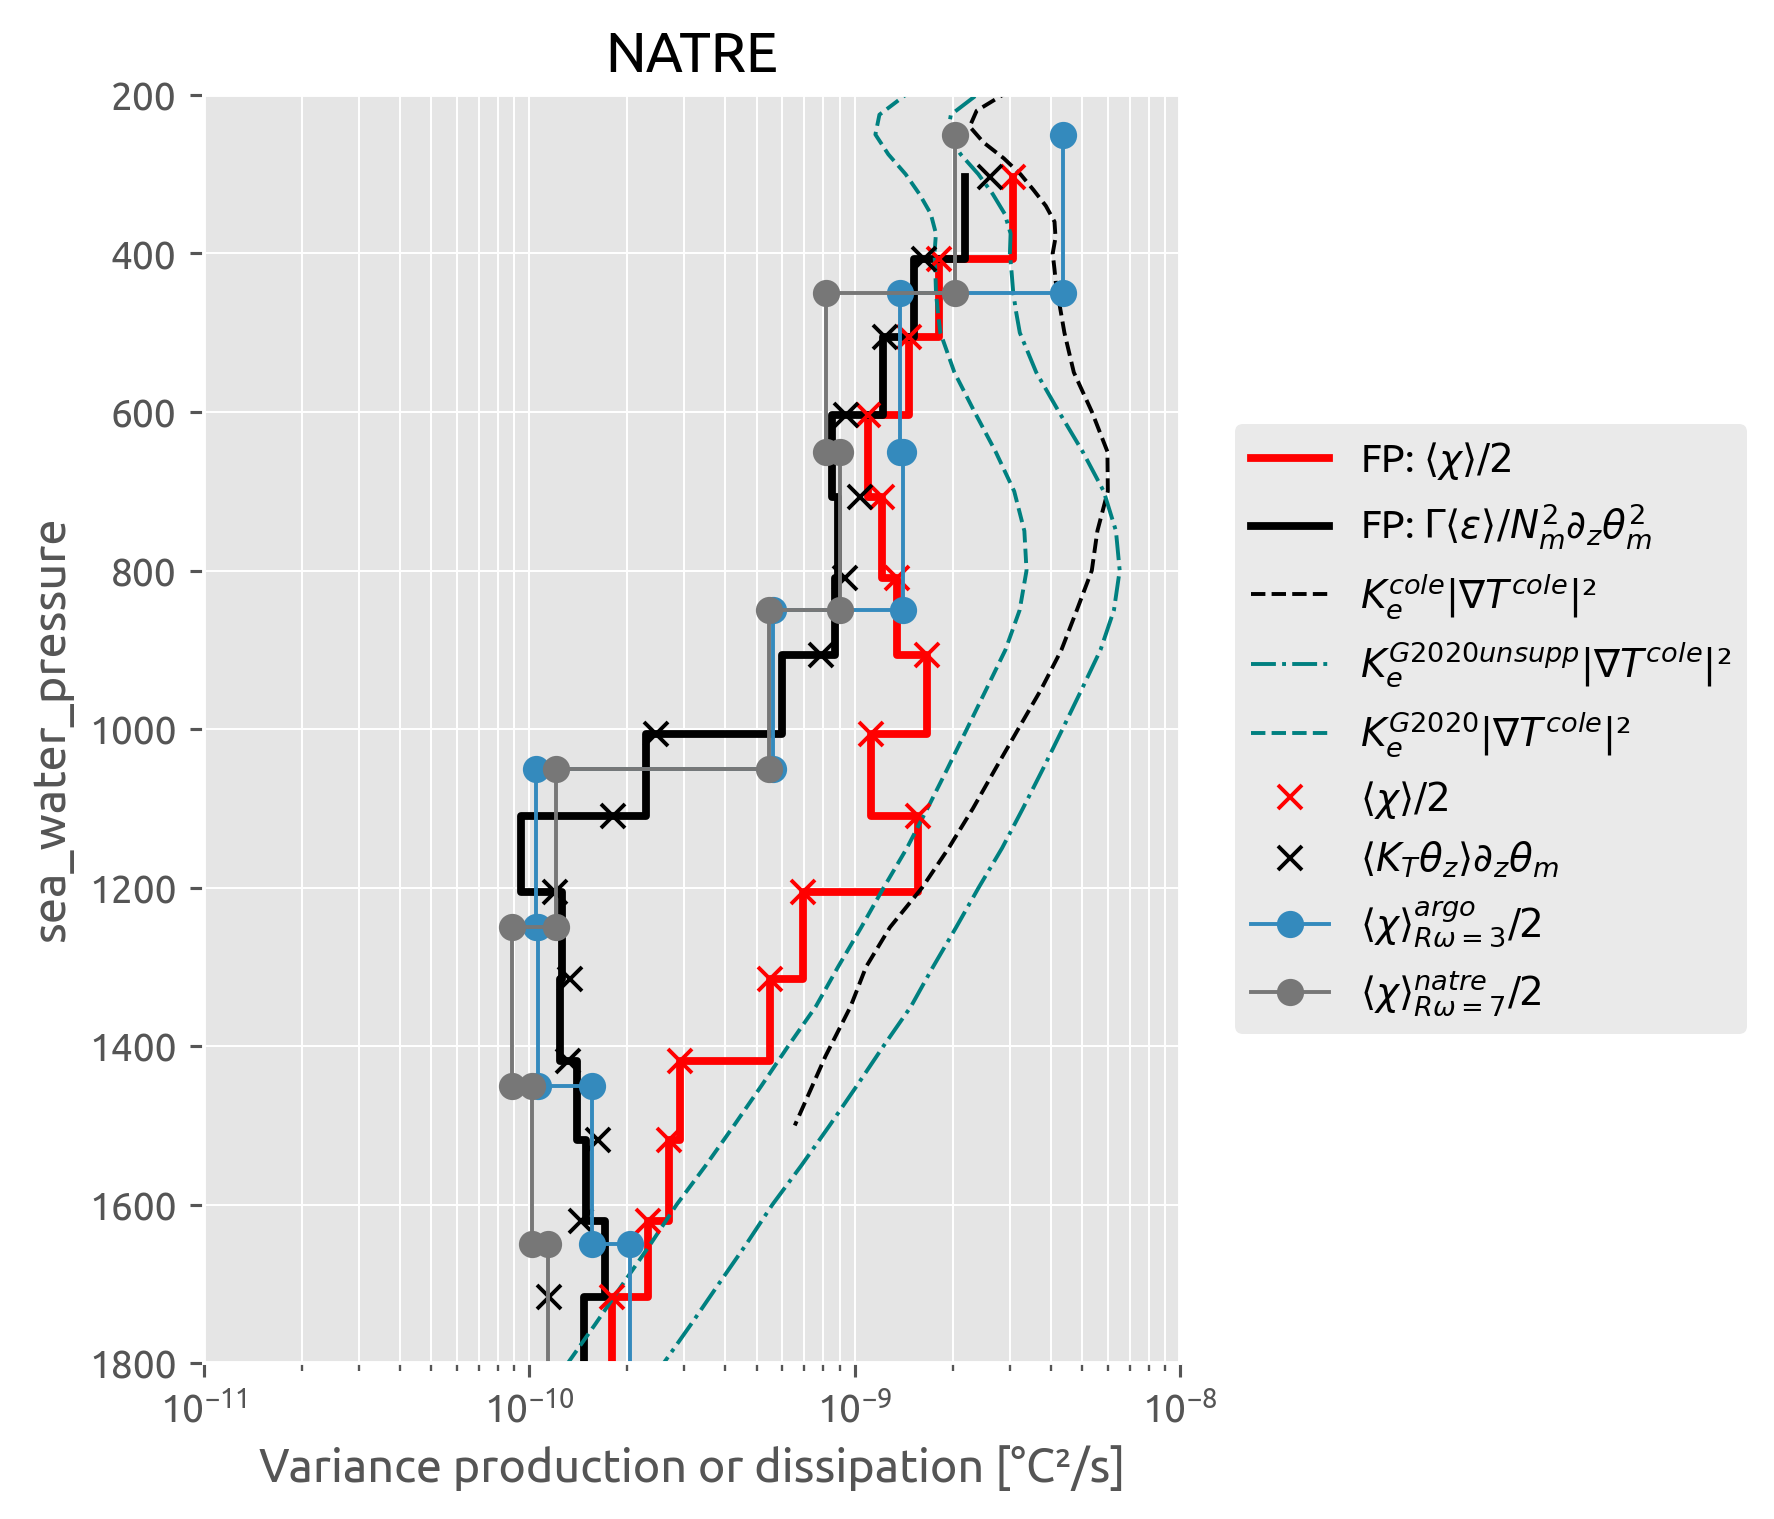

In [17]:
f, ax = plt.subplots(1, 1)  # , constrained_layout=True)

(micro.chi / 2).cf.plot.step(
    y="pres",
    color="r",
    label="FP: $⟨χ⟩/2$",
    lw=2,
    xlim=(1e-11, 1e-8),
    ylim=(1800, 200),
)
(micro.Krho_m * micro.dTdz_m ** 2).cf.plot.step(
    color="k", lw=2, y="pres", label="FP: $Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$"
)

cole_var.plot(y="pres", label="$K_e^{cole} |∇T^{cole}|²$", color="k", ls="--")

groeskamp.eddy_var_0.plot(
    y="depth", label="$K_e^{G2020unsupp} |∇T^{cole}|²$", color="teal", ls="-."
)
groeskamp.eddy_var.plot(
    y="pres", label="$K_e^{G2020} |∇T^{cole}|²$", color="teal", ls="--"
)

ed.sections.plot_var_prod_diss(micro, ls="none", marker="x", ax=plt.gca())

(argo_fine_depth.χ.sel(criteria="whalen") / 2).cf.plot.step(
    marker="o",
    color="C1",
    ax=plt.gca(),
    y="pressure_bins",
    label="$⟨χ⟩^{argo}_{Rω=3}/2$",
)

# (natre_fine_avg.χ.sel(criteria="whalen") / 2).cf.plot.step(
#    marker="o", color="C2", ax=plt.gca(), label="$⟨χ⟩_{fine-3}^{natre}/2$"
# )
(natre_fine_avg.χ.sel(criteria="whalen_7") / 2).cf.plot.step(
    marker="o", color="C3", ax=plt.gca(), label="$⟨χ⟩_{Rω=7}^{natre}/2$"
)

# (micro.chi / 2 - micro.Krho * micro.dTdz ** 2).cf.plot.step(
#    y="pres",
#   xscale="log",
#   xlim=(1e-11, 1e-8),
#   ylim=(1800, 200),
#   color="darkblue",
#   lw=1,
#   label="$⟨χ⟩/2 - K_ρ θ^m_z$",
# )

plt.legend(loc="right", bbox_to_anchor=(1.6, 0.5))
plt.xlabel("Variance production or dissipation [°C²/s]")
plt.gcf().set_size_inches((4.5, 6))
plt.title("NATRE")
plt.gcf().savefig("../images/natre-estimate.png")

## POP2 1/10° mesoscale variance budget

Yiming is working with the following variance budget equation for the mesoscale after decomposing $T = \bar{T} + T' + T'' ≡ T_m + T_e + T_t$ (the latter is Ferrari & Polzin notation). The $T = \tilde{T} + T''$ decomposition is inherent when using cell-averaged equations.

\begin{equation}
∂_t \overline{T'^2} =  -\overline{u'T'} ⋅ ∇_h\overline{T} - \overline{w'T'}∂_z\overline{T} - \overline{\vec{v} ⋅ ∇ T'^2/2} + \overline{T'∂_z \left[K ∂_zT' \right]} + …
\end{equation}

Ferrari & Polzin's equations (4.6, 4.7) for the mesoscale and microscale are ($u$ here is the full 3D $u$):
\begin{align}
⟨u_eT_e⟩ ⋅ ∇T_m - ⟨\widetilde{u_t T_t} ⋅ ∇T_e⟩ &= 0 \\
⟨u_tT_t⟩ ⋅ ∇ T_m + ⟨\widetilde{u_t T_t} ⋅ ∇ T_e⟩ &= - \frac 12 ⟨χ⟩
\end{align}
Note that these equations are specialized for the "interior".

For the model the averaging scales are:
1. ~: grid-scale in vertical; single time-step in time i.e. the "microscale" is the "grid-scale"
2. ⟨⟩: monthly in time; NATRE domain size in (x,y)

In Yiming's notation these equations are
\begin{align}
\overline{u'T'}⋅∇\overline{T} + \overline{w'T'}∂_z\overline{T}  - \overline{T'∂_z \left[K ∂_zT' \right]} = 0 \\
K \left(∂_z(\overline{T} + T')\right)^2  &= - \frac 12 ⟨χ⟩
\end{align}

Now we can identify Yiming's dissipation term ("VMIX", ignoring solar heating etc.) as the scale transformation term in FP2005 and then use the microscale budget from FP2005 to write
\begin{equation}
⟨\widetilde{u_t T_t} ⋅ ∇T_e⟩ = - \frac 12 ⟨χ⟩ - ⟨u_tT_t⟩ ⋅ ∇ T_m
\end{equation}

i.e. Yiming's "mesoscale dissipation" term is really the difference between
1. total microscale dissipation, and 
2. microscale production by stirring of the mean vertical gradient, 

both of which can be estimated from microstructure observations. 

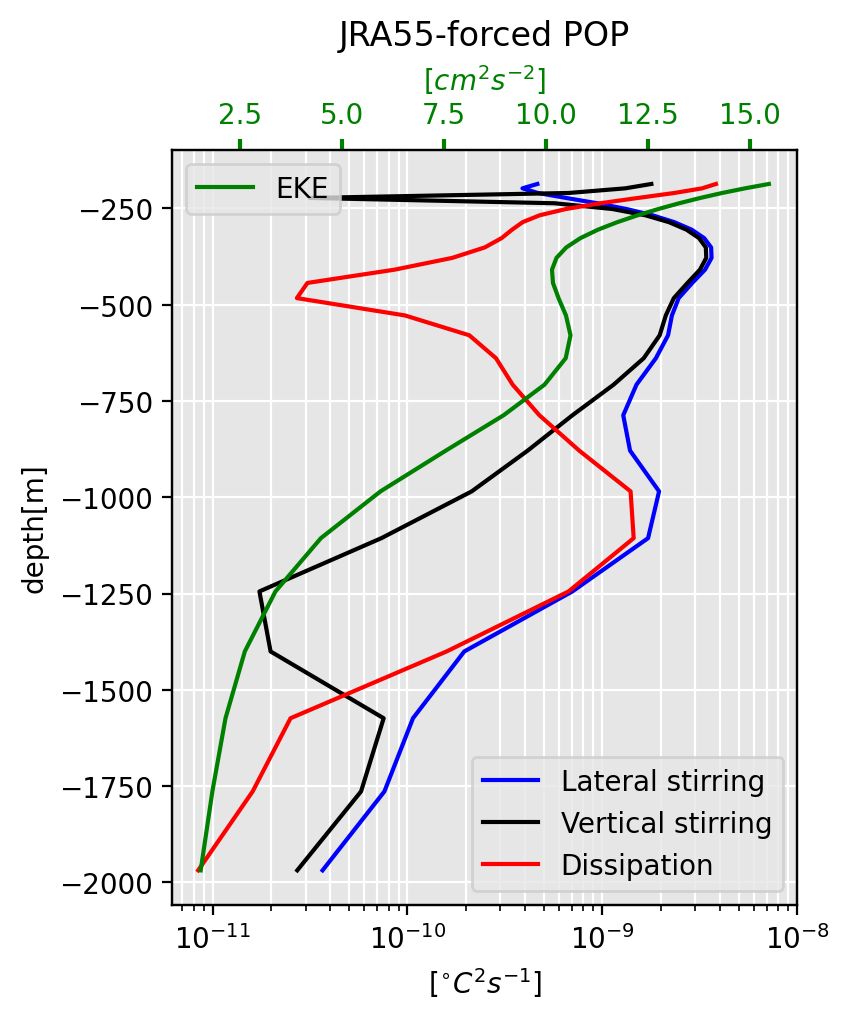

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [18]:
Image("../images/Tvariance_budget_NATREregion_with_EKE.png", width=600)

## Error bounds

### Microstructure

Ferrari & Polzin (2005):

     The variance of ε (and χ) are calculated using a bootstrap method (Efron 1982). The number of degrees of freedom in the bootstrap estimate is determined from the number of independent vertical segments in the ensemble. The number of independent vertical segments in the 0.5-m ε (and χ) data was estimated using a vertical-lag correlation analysis (St.Laurent and Schmitt 1999). The profiles are characterized by correlation scales of 5 m in the thermocline (< 800 m) and 10 m at greater depths. A single degree of freedom is represented by the grouping of 0.5-m data within one correlation scale in a single profile. For the ensemble of data in each neutral density class, the number of such groupings gives the total degrees of freedom.


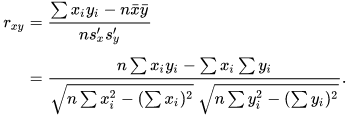

## Studying Cole estimate

Previously I was seeing some big disagreement. This was due to gradients estimated in depth-space instead of in isopycnal space.

### Compare Cole & Groeskamp diffusivities


Reproducing Groeskamp Figure 1. This seems to work well; but note the different domain. I saw this in his MATLAB script.
```
%% MIXING IN NATRE REGION
% THE NATRE REGIONS LIES BETWEEN
% 319.5 - 344.5 degrees lon
%  19.5 -  29.5 degrees lat
NATRE_x = 320:345;
NATRE_y = 110:120;
```

/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


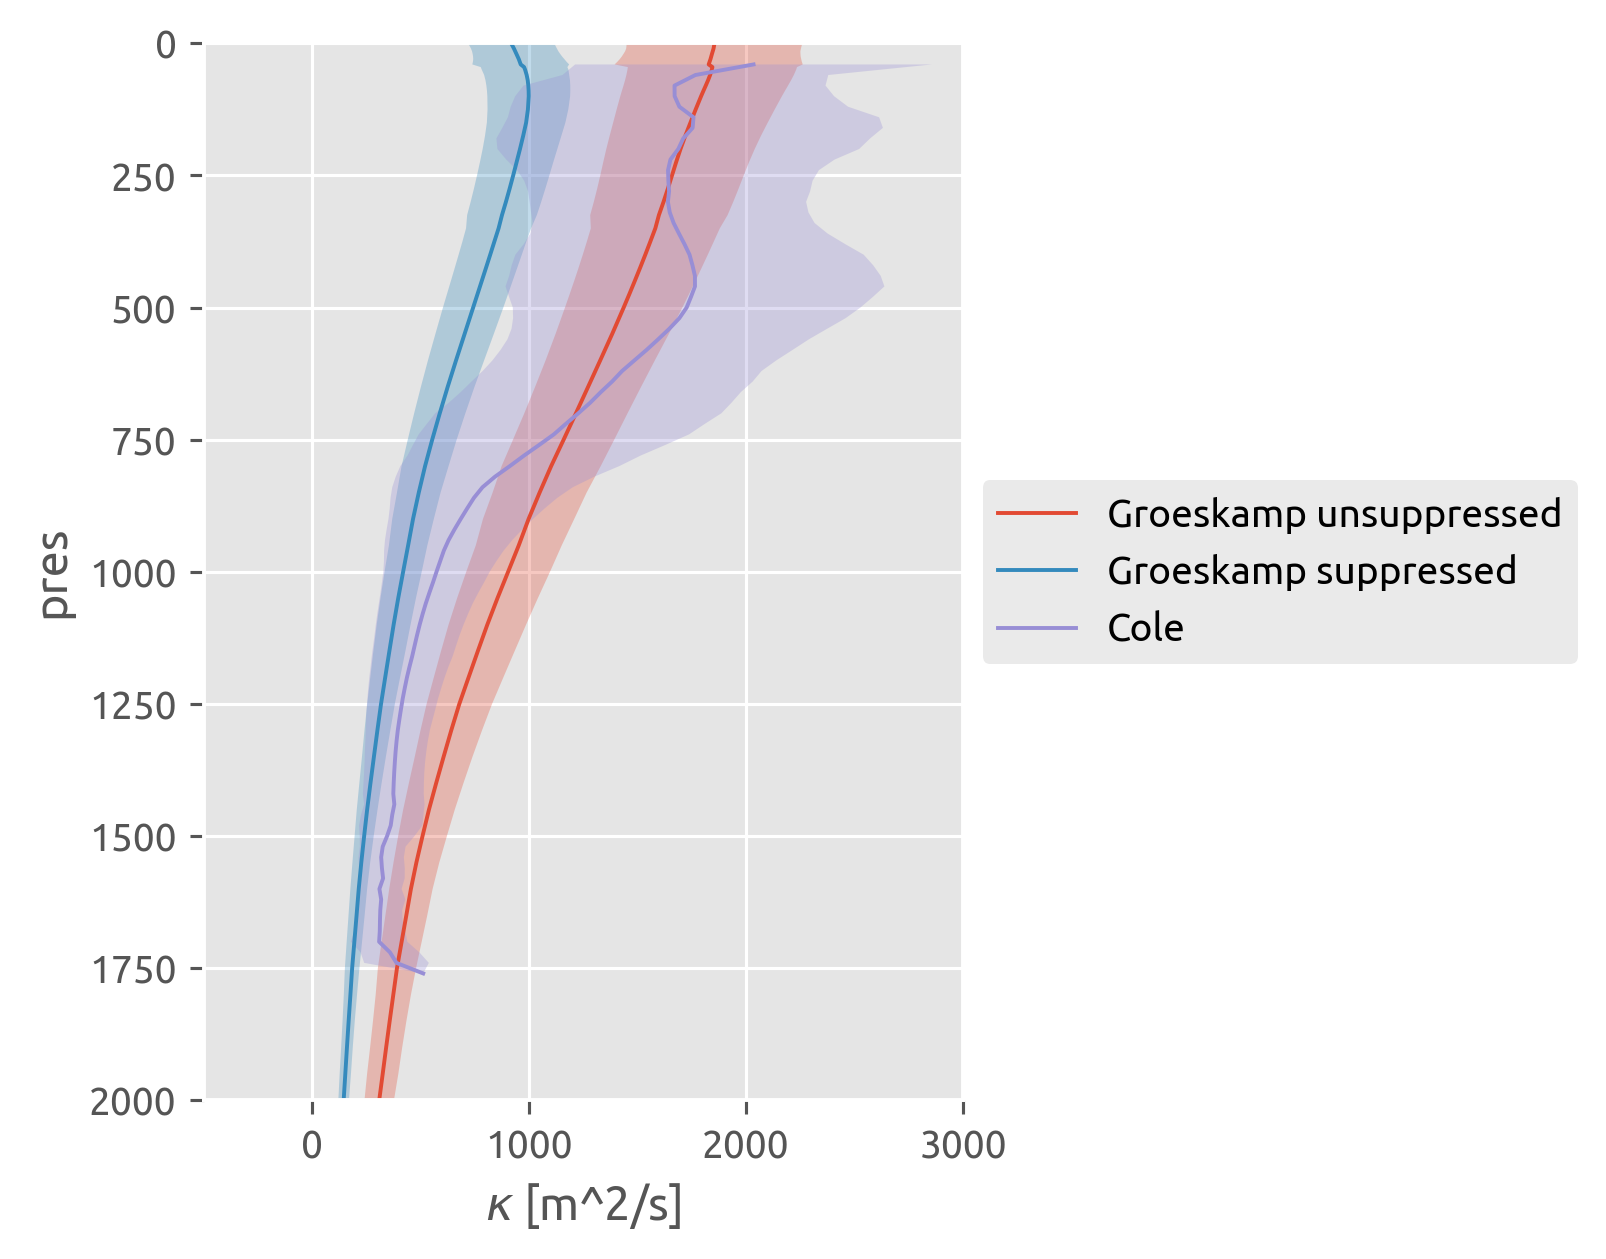

In [92]:
cole = ed.read_cole(resolution="3deg").sel(
    lat=slice(19.5, 29.5), lon=slice(319.5, 344.5)
)
groeskamp = (
    xr.open_dataset("/home/deepak/datasets/groeskamp2020/groeskamp2020.nc")
    .sel(lat=slice(19.5, 29.5), lon=slice(319.5, 344.5))
    .rename({"depth": "pres"})
)


def plot_mean_std(da, label):
    mean = da.mean(["lat", "lon"])
    std = da.std(["lat", "lon"])
    (hdl,) = mean.cf.plot(ylim=(2000, 0), label=label)
    dcpy.plots.fill_between(
        xr.concat((mean - std, mean + std), dim="err"),
        axis="x",
        x="err",
        y="pres",
        alpha=0.3,
    )


plot_mean_std(groeskamp.Ke_0, label="Groeskamp unsuppressed")
plot_mean_std(groeskamp.Ke, label="Groeskamp suppressed")
plot_mean_std(cole.diffusivity, label="Cole")
plt.gcf().set_size_inches((3.5, 5))
plt.gca().set_xlim((-500, 3000))
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

### Depth-vs-density space estimation of $K_e |∇T|²$

Turns out this does not matter; I was worried that diffusivity in depth space and |∇T| estimated in density space might combine badly. But moving diffusivity to sigma space or |∇T| to depth space results in same mean variance tendency

In [222]:
cole = ed.read_cole()

import xgcm

cole["diffusivity_sig"] = xgcm.transform.linear_interpolation(
    cole.diffusivity, cole.density_mean_depth, cole.sigma, "pres", "pres", "sigma"
)

# read, take mean in region; swap to pressure coordinate
colegrad = xr.open_dataset("../datasets/cole-clim-gradient-natre.nc").sel(
    lat=slice(24, 28), lon=slice(360 - 30, 360 - 25)
)
colegrad["sigma"] = cole.sigma

cole_natre = cole[
    ["diffusivity", "diffusivity_sig", "density_mean_depth", "depth_mean_sig"]
].interp(lat=colegrad.lat.data, lon=colegrad.lon.data)
dTiso_pres = xgcm.transform.linear_interpolation(
    colegrad.dTiso,
    colegrad.pres,
    cole.pres,
    "sigma",
    "sigma",
    "pres",
)

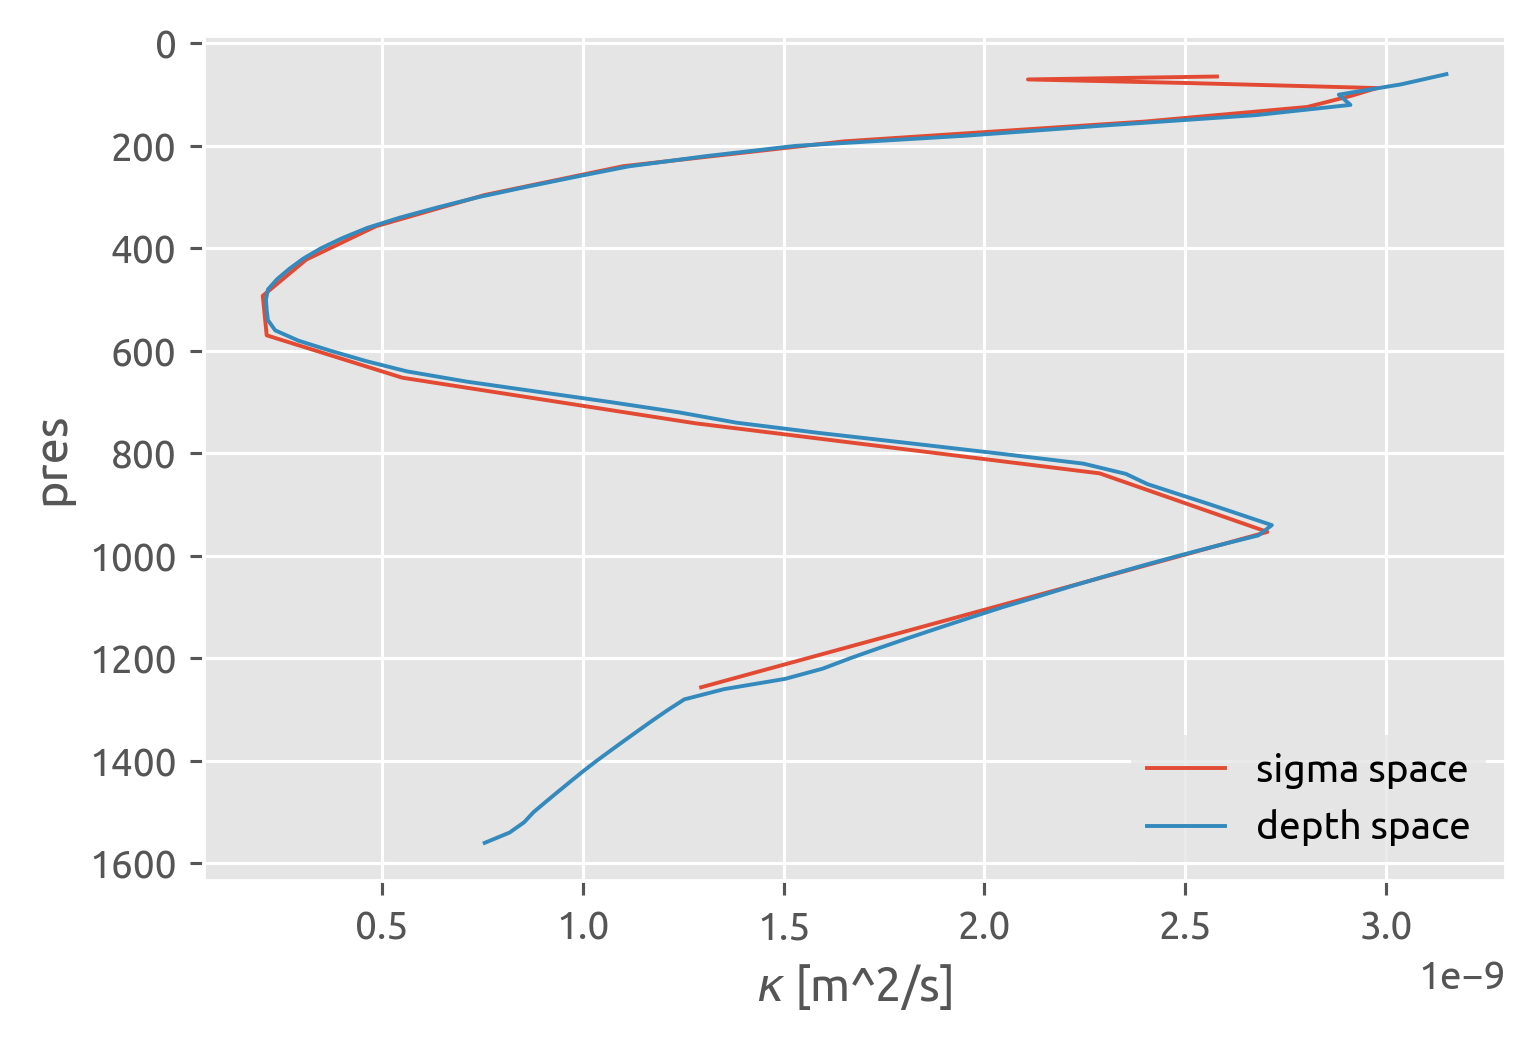

In [235]:
cole_var_sig = (
    (cole_natre.diffusivity_sig * colegrad.dTiso ** 2)
    .mean(["lat", "lon"])
    .assign_coords(pres=cole_natre.depth_mean_sig.mean(["lat", "lon"]))
)
cole_var_pres = (cole_natre.diffusivity * dTiso_pres ** 2).mean(["lat", "lon"])

cole_var_sig.plot(y="pres")
cole_var_pres.plot(y="pres", yincrease=False)
plt.legend(["sigma space", "depth space"])

### Depth space calculation

The following is when I was using $|∇T|$ estimated in depth space and multiplying by a $K_e$ provided in depth space


**Initial surprising observation**: We expect to see peak $K_e$ between 600 and 1600m but we mostly don't! Both $⟨S'S'⟩$ and $|∇S|$ are large in the depth we expect a peak. There seems to be approximate agreement in the 1000-1200m range at (-34°E, -32°E) but missing data at deeper depths

Here are estimates of variance produced by eddy stirring at points in the NATRE box from Cole et al (2015). There is some spread but the peak between 400 and 1000 seems robust. Thick black line is the mean over the box.

Text(0.5, 0, '$K_e^{cole} |∇T_{iso}^{argo}|²$ [°C²/s]')

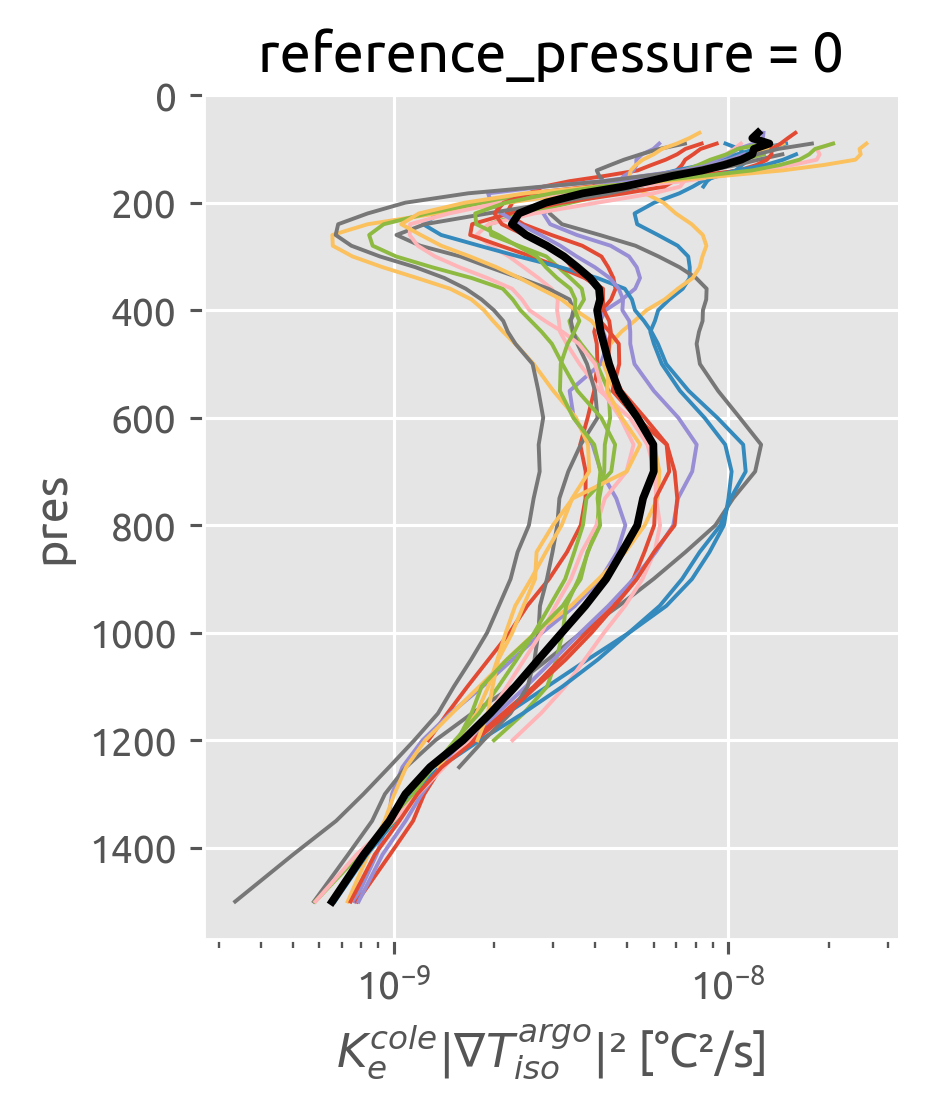

In [32]:
cole_var_all.stack(latlon=["lat", "lon"]).drop("latlon").cf.plot.line(
    y="pres", add_legend=False, size=4, aspect=0.8, xscale="log"
)
cole_var.cf.plot(color="k", lw=2)
plt.xlabel("$K_e^{cole} |∇T_{iso}^{argo}|²$ [°C²/s]")
# (cole.diffusivity.interp_like(dTiso) * colegrad.dSiso**2).mean(["lat", "lon"]).cf.plot()

These are the various terms in the Cole analysis. Note minimum in ∇S between 200 and 800, and associated high mixing lengths ≳ 300km.

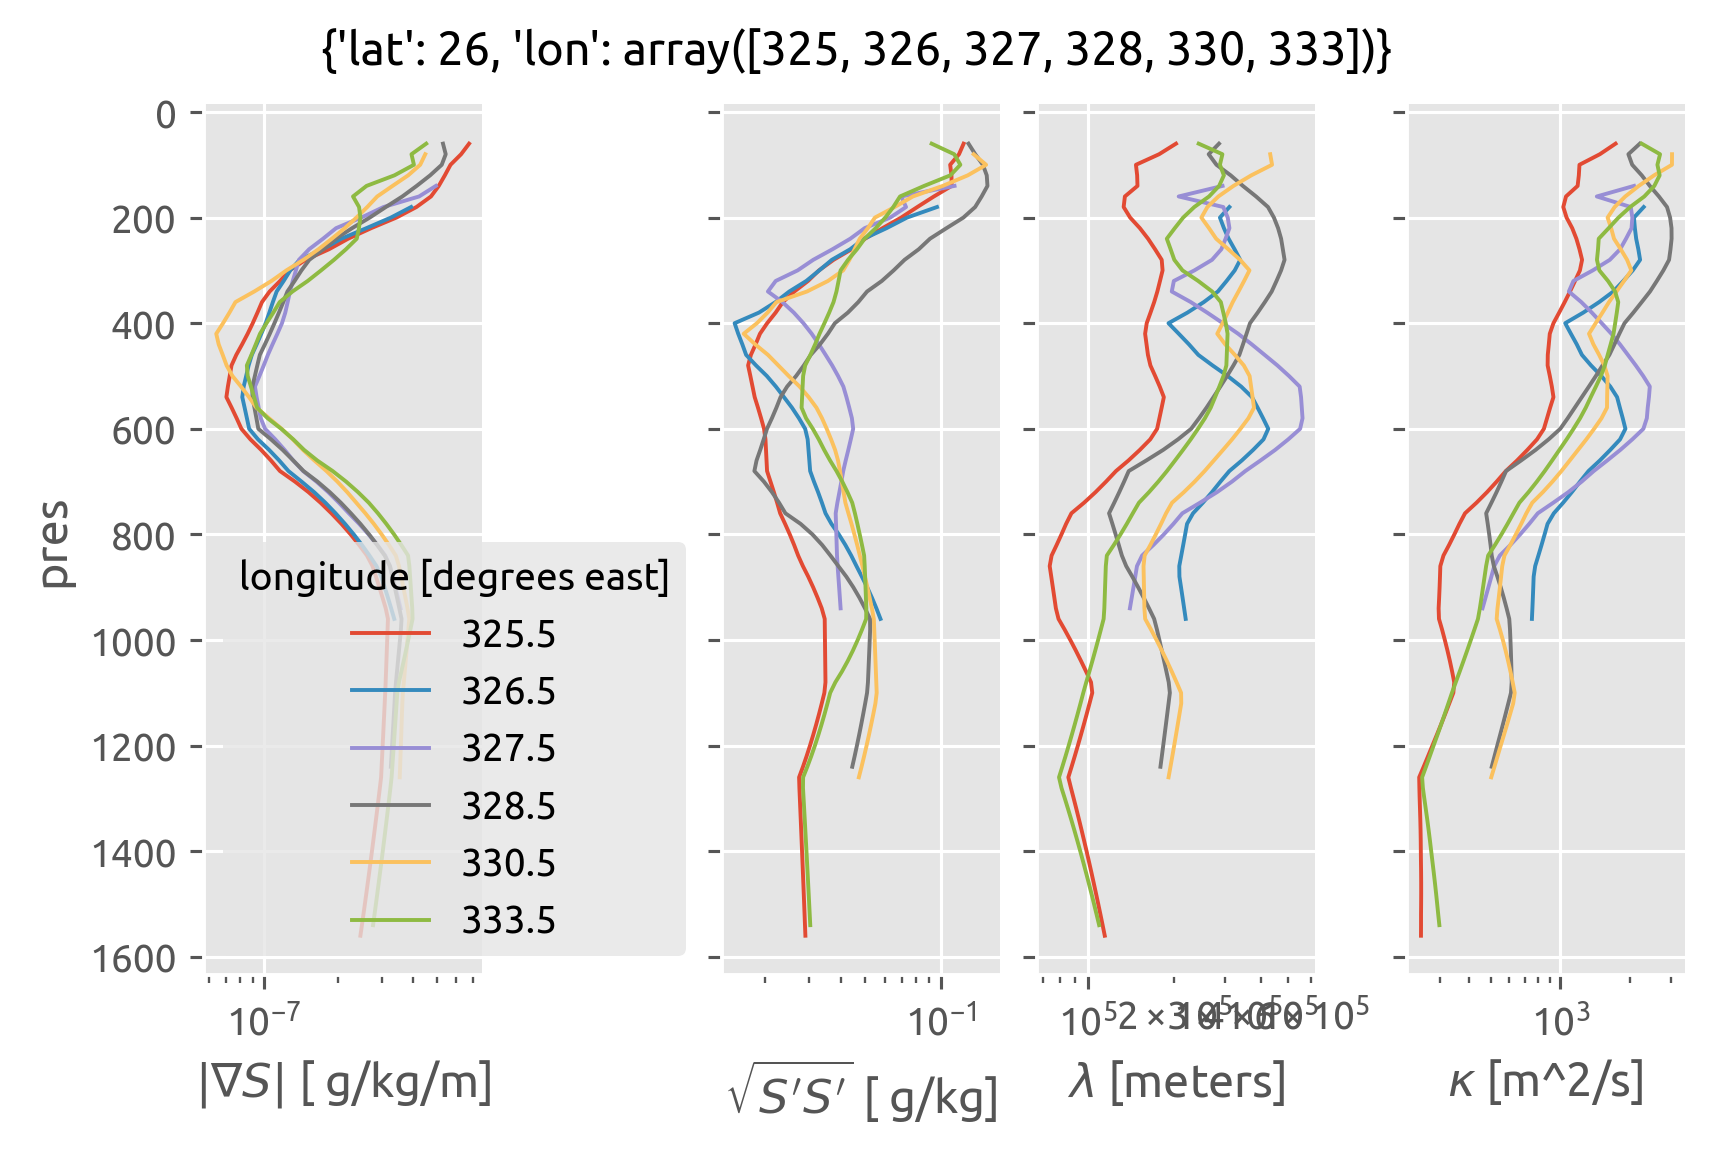

In [68]:
ed.plot.plot_cole_profile(lat=26, lon=360 + np.array([-35, -34, -33, -32, -30, -27]))

## T-S diagrams: Argo vs. NATRE

Lets compare T-S to see if they are similar. I am exploring ways to 

1. interpret the "high" variance production values between 400m and 800m for the Cole estimate. Maybe the NATRE T-S is not representative of the argo T-S?
    - It is representative!
2. explain why the Argo ⟨χ⟩ seems to miss any eddy contribution. Is the scatter less at those density levels?
    - There is some undersampling (of course) because the sampling dz is low below 1000m usually.
    - It seems to capture some of the spread; but the NATRE dataset seems to fill up the space more.
   

The density contours are ρ corresponding to depths `np.arange(200, 2000, 200)` in the Cole dataset. Clearly the top few contours see not much T-S stirring and the T-S relationship is "tight". Ferrari & Polzin interpreted this as a balance between microscale stirring and dissipation. 
- So the high K_e estimate between 400m and 800m in Cole et al (2015) is not supported by the TS spread. 
- Though interestingly the Groeskamp estimate has the same issue then.


Is the finestructure estimate undersampling eddy stirring periods? Compare T-S spread for 
1. all argo profiles
2. argo profiles where I can make a finestructure estimate.
3. NATRE profiles

In [127]:
argo_natre = xr.load_dataset("../datasets/argo/natre.nc")
argo_natre["THETA"] = dcpy.eos.ptmp(
    argo_natre.PSAL, argo_natre.TEMP, argo_natre.PRES, natre.reference_pressure.item()
)
argo_fine_full_profiles = xr.load_dataset("argo_profiles_used_for_finestructure.nc")

In [255]:
# choose density levels that highlight the depth range we are interested in
rho_levels = (
    cole.density_mean_depth.interp_like(colegrad)
    .mean(["lat", "lon"])
    .sel(pres=np.arange(200, 2000, 200), method="nearest")
)

### All argo vs NATRE

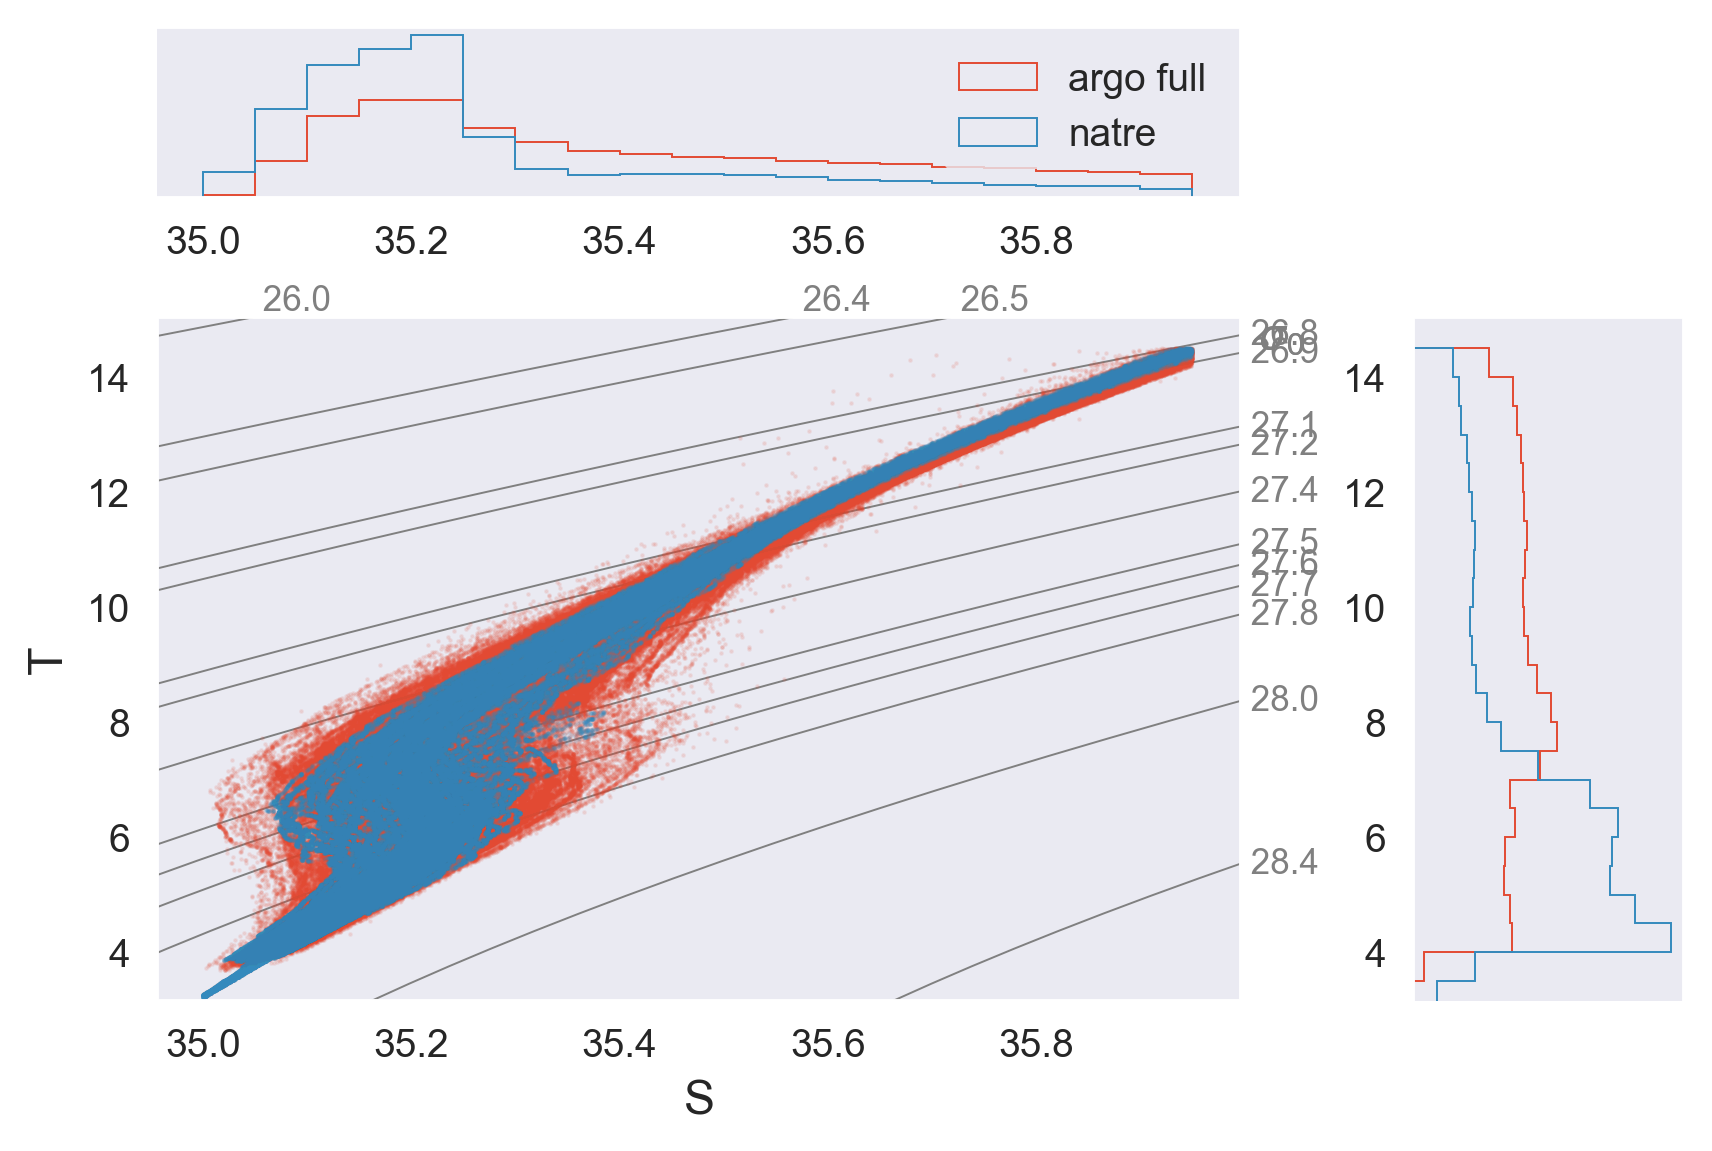

In [260]:
kwargs = dict(
    hexbin=False,
    size=0.5,
    plot_kwargs={"alpha": 0.1},
    Sbins=np.arange(35, 36, 0.05),
    Tbins=np.arange(2, 15, 0.5),
    Pref=0,
)

_, ax = dcpy.oceans.TSplot(
    argo_natre.PSAL,
    argo_natre.THETA,
    **kwargs,
    rho_levels=rho_levels,
)

# mask = argo_fine_full_profiles.fine_deepest_bin > 1000

# _, ax = dcpy.oceans.TSplot(
#    argo_fine_full_profiles.where(mask, drop=True).PSAL,
#    argo_fine_full_profiles.where(mask, drop=True).THETA,
#    **kwargs,
#    rho_levels=rho_levels,
# )

dcpy.oceans.TSplot(
    natre.salt,
    natre.theta,
    ax=ax,
    **kwargs,
)

ax["s"].legend(["argo full", "natre"])
plt.gcf().savefig("../images/ts-natre.png")

### Finestructure Argo vs NATRE

In [261]:
kwargs = dict(
    hexbin=False,
    size=0.5,
    plot_kwargs={"alpha": 0.1},
    Sbins=np.arange(35, 36, 0.05),
    Tbins=np.arange(2, 10, 0.5),
    Pref=0,
)

The distributions look similar and the argo data capture more extremes; but the NATRE data fill a lot of the space (though smaller S.D.). Maybe the average isn't that great and it's totally undersampling

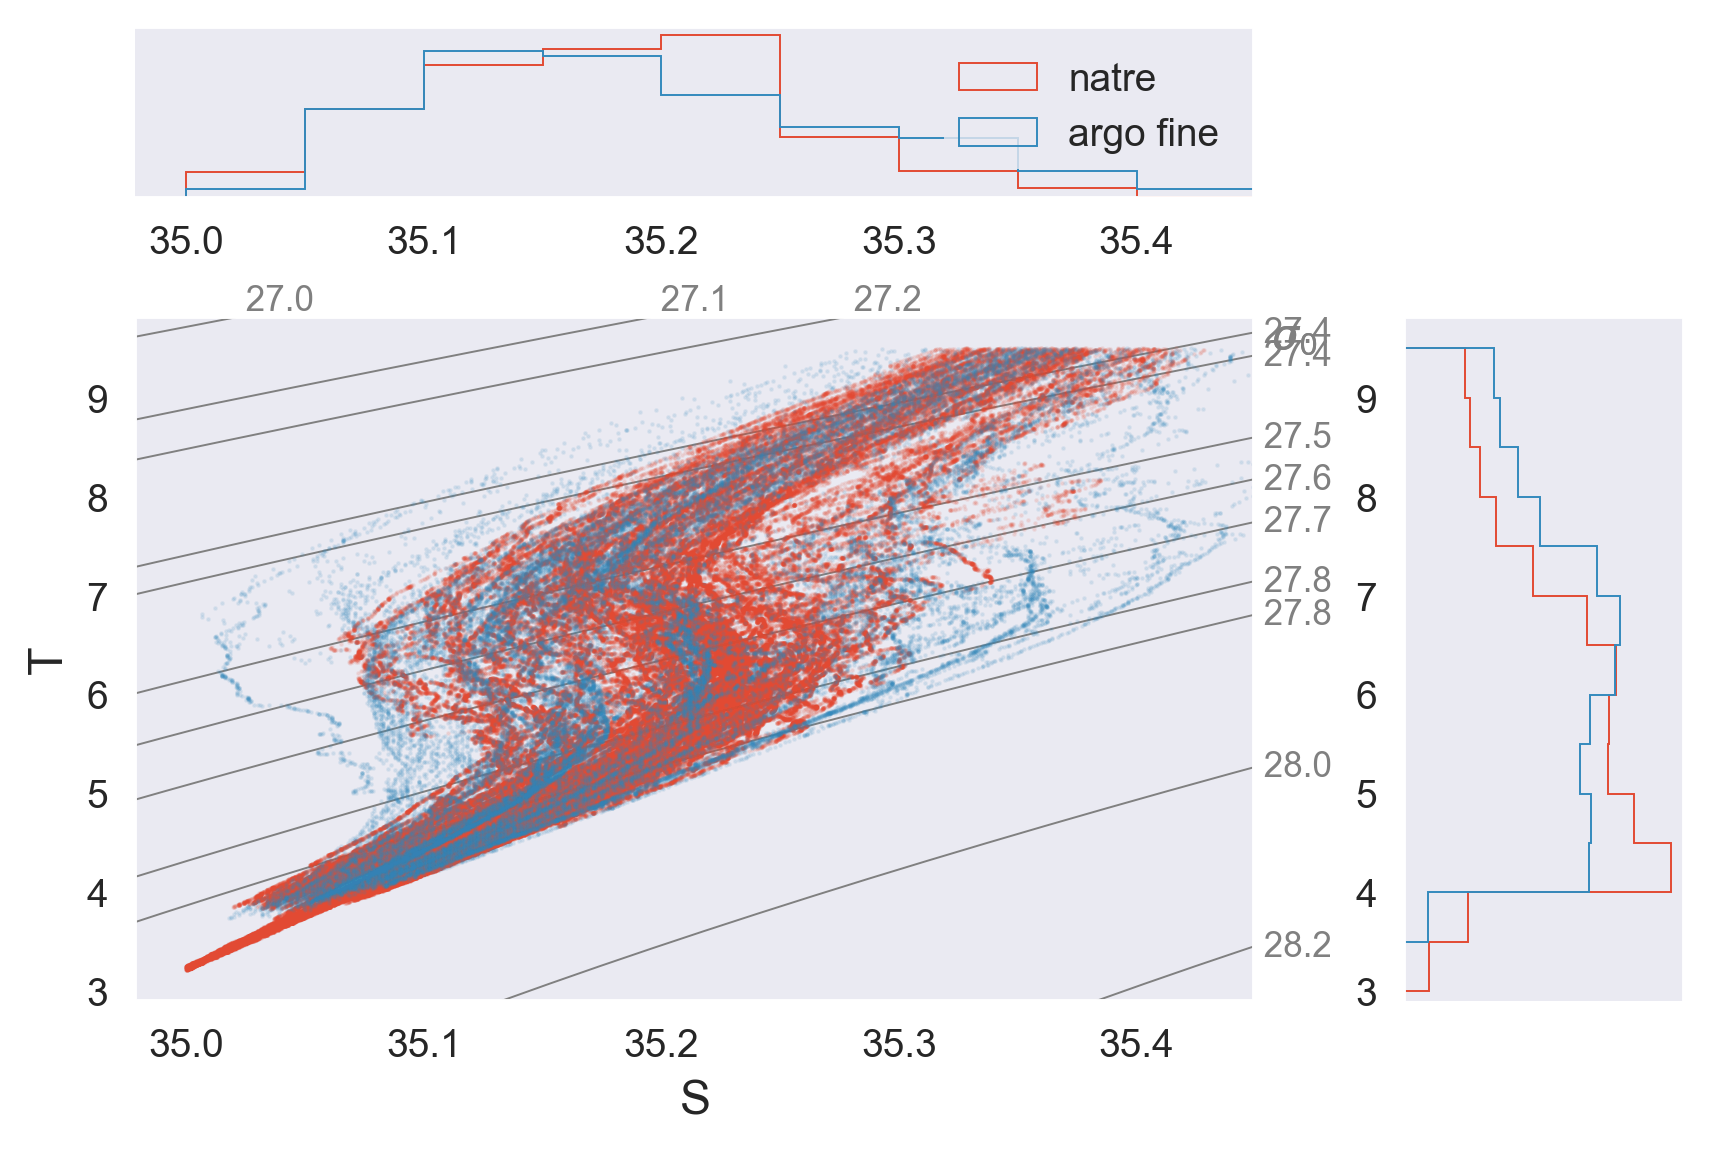

In [266]:
mask = argo_fine_full_profiles.fine_deepest_bin > 1000

_, ax = dcpy.oceans.TSplot(
    natre.salt,
    natre.theta,
    **kwargs,
    rho_levels=rho_levels,
)

dcpy.oceans.TSplot(
    argo_fine_full_profiles.where(mask, drop=True).PSAL,
    argo_fine_full_profiles.where(mask, drop=True).THETA,
    ax=ax,
    **kwargs,
)

ax["s"].legend(["natre", "argo fine"])
plt.gcf().savefig("../images/ts-natre.png")

It's definitely a big undersampling when compared to all Argo profiles in the area. **How good is good enough?** 

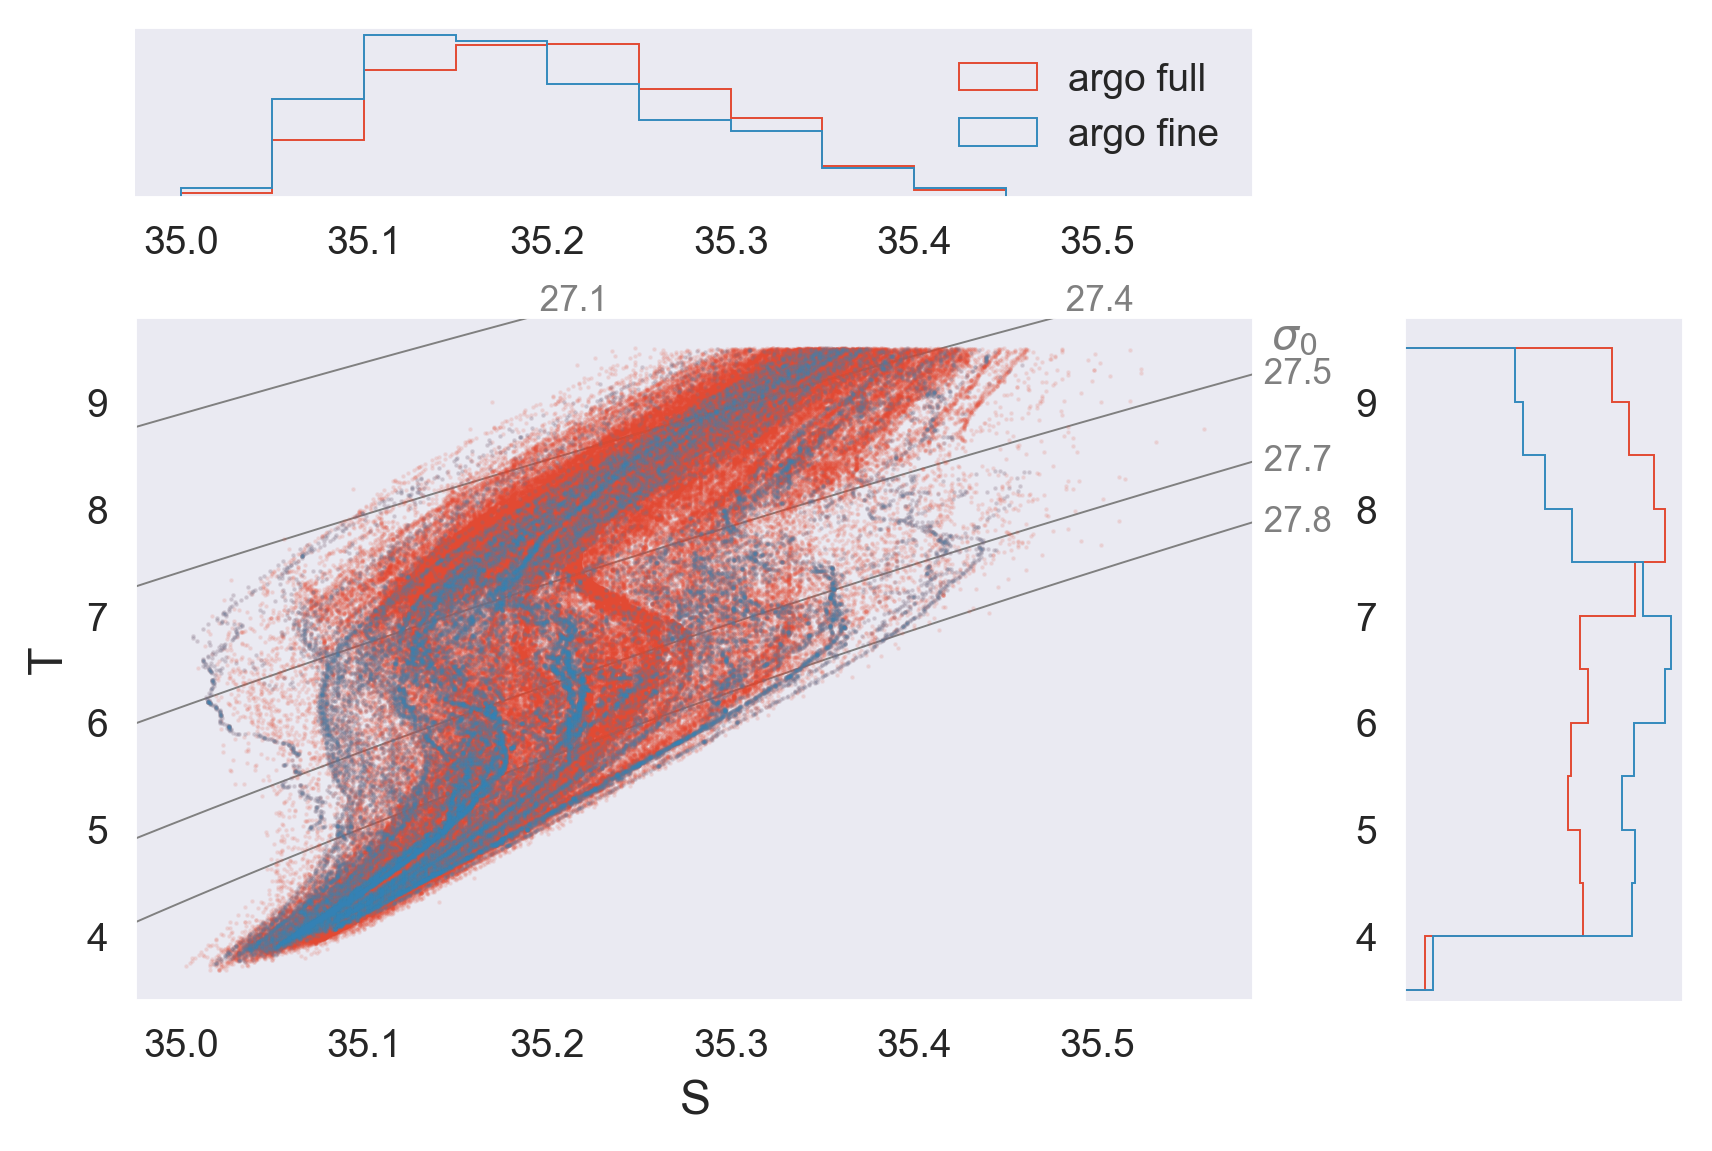

In [267]:
_, ax = dcpy.oceans.TSplot(
    argo_natre.PSAL,
    argo_natre.THETA,
    **kwargs,
    rho_levels=rho_levels,
)

mask = argo_fine_full_profiles.fine_deepest_bin > 1000


masked = argo_fine_full_profiles.where(mask, drop=True)
_, ax = dcpy.oceans.TSplot(
    masked.PSAL,
    masked.THETA,
    ax=ax,
    rho_levels=None,
    **kwargs,
)


masked.groupby
ax["s"].legend(["argo full", "argo fine"])
plt.gcf().savefig("../images/ts-natre-argo.png")

### Conclusions

1. Can we define a metric using (T-S spread in all argo profiles) vs (TS spread in profiles where we can make a finestructure estimate) to decide where we might be able to make an estimate using Argo?
2. Can we refine this?
    - If we expect regions above 1000m then it might not be so bad.
    - Could make a bigger box? (skeptical)
    
3. This really points out the limitation of the finestructure estimate, at least deeper down?
    - How does the Whalen scatter plot work out?

### Is there spatial uncertainty? Cole estimate: Are we looking in the wrong place? No

Here's the NATRE region marked on a map of $K_e$. There is just low diffusivity everywhere in the box; but may be the mean signal is just northwest of the box

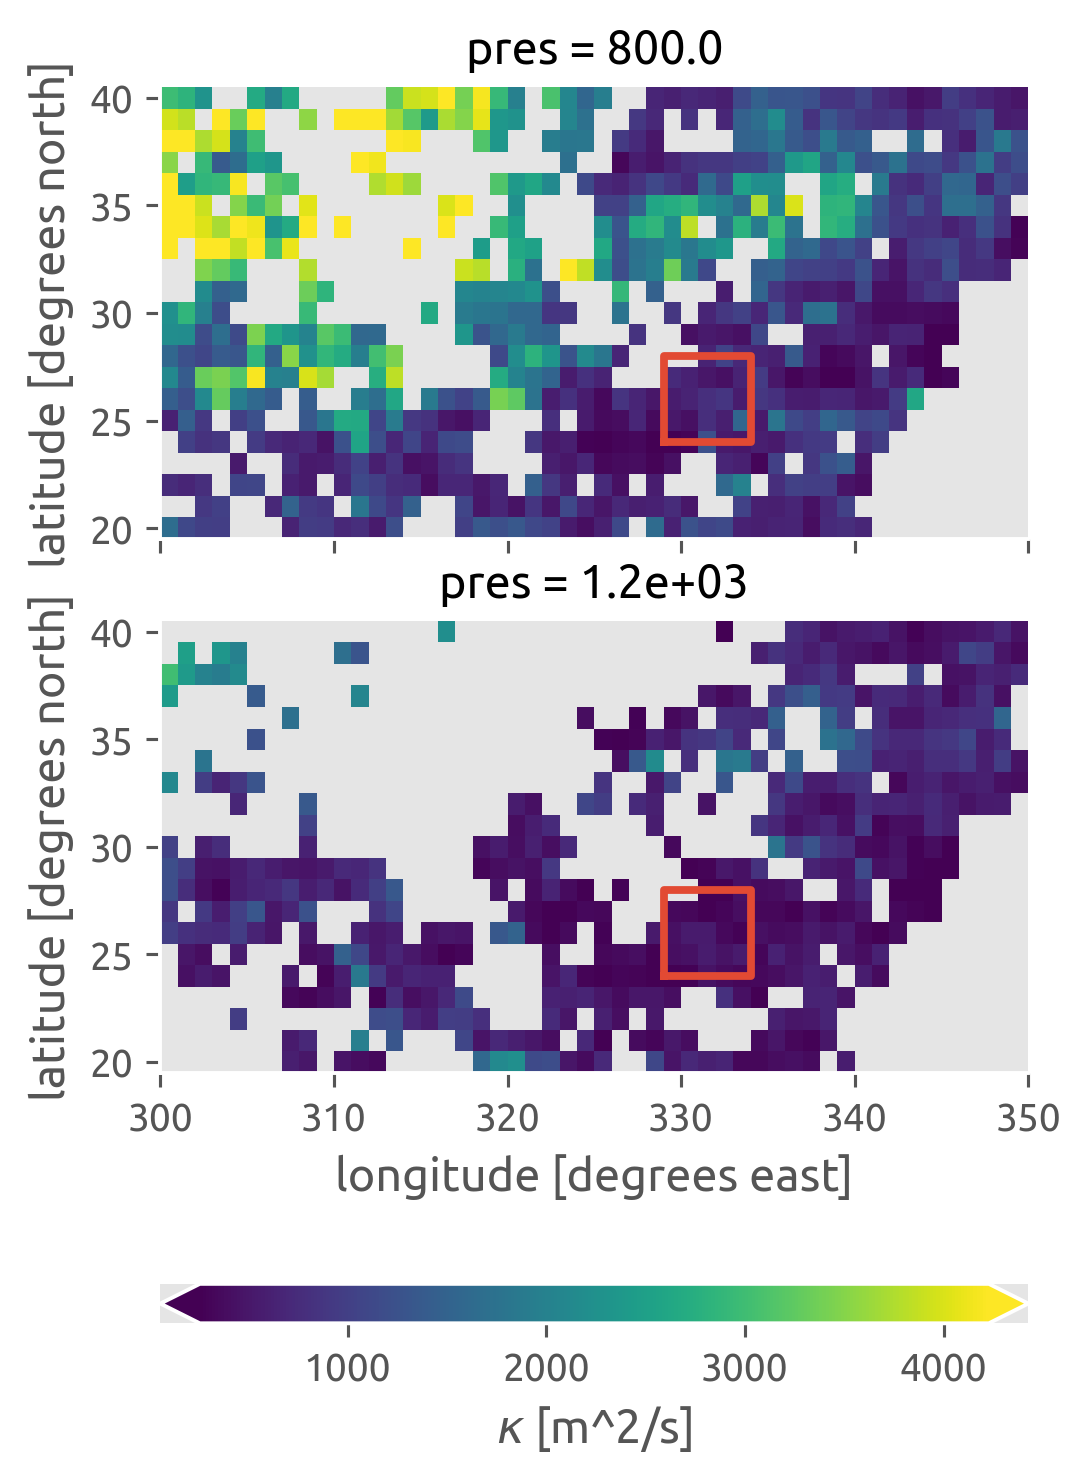

In [56]:
fg = (
    cole.diffusivity.sel(pres=[800, 1200], method="nearest")
    .sel(lon=slice(300, 350), lat=slice(20, 40))
    .plot(robust=True, row="pres", cbar_kwargs={"orientation": "horizontal"})
)

fg.map(
    lambda: plt.plot(
        360 + np.array([-31, -26, -26, -31, -31]), [24, 24, 28, 28, 24], lw=2
    )
)

## Sensitivity of χpod estimate to mean K estimate

Various estimates of the variance produced by turbulent stirring of mean vertical gradient

1. Ferrai & Polzin (2005): $Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$ 
2. χpod estimate: $⟨K_T θ_z⟩ ∂_zθ_m$
3. (1) with $ε_χ$ : $Γ ⟨ε_χ⟩/N_m^2  ∂_zθ_m^2$
4. (2) with $K_ρ$ instead of $K_T$: $⟨K_ρ θ_z⟩  ∂_zθ_m^2$; $K_ρ ≪ K_T$, so this is not good

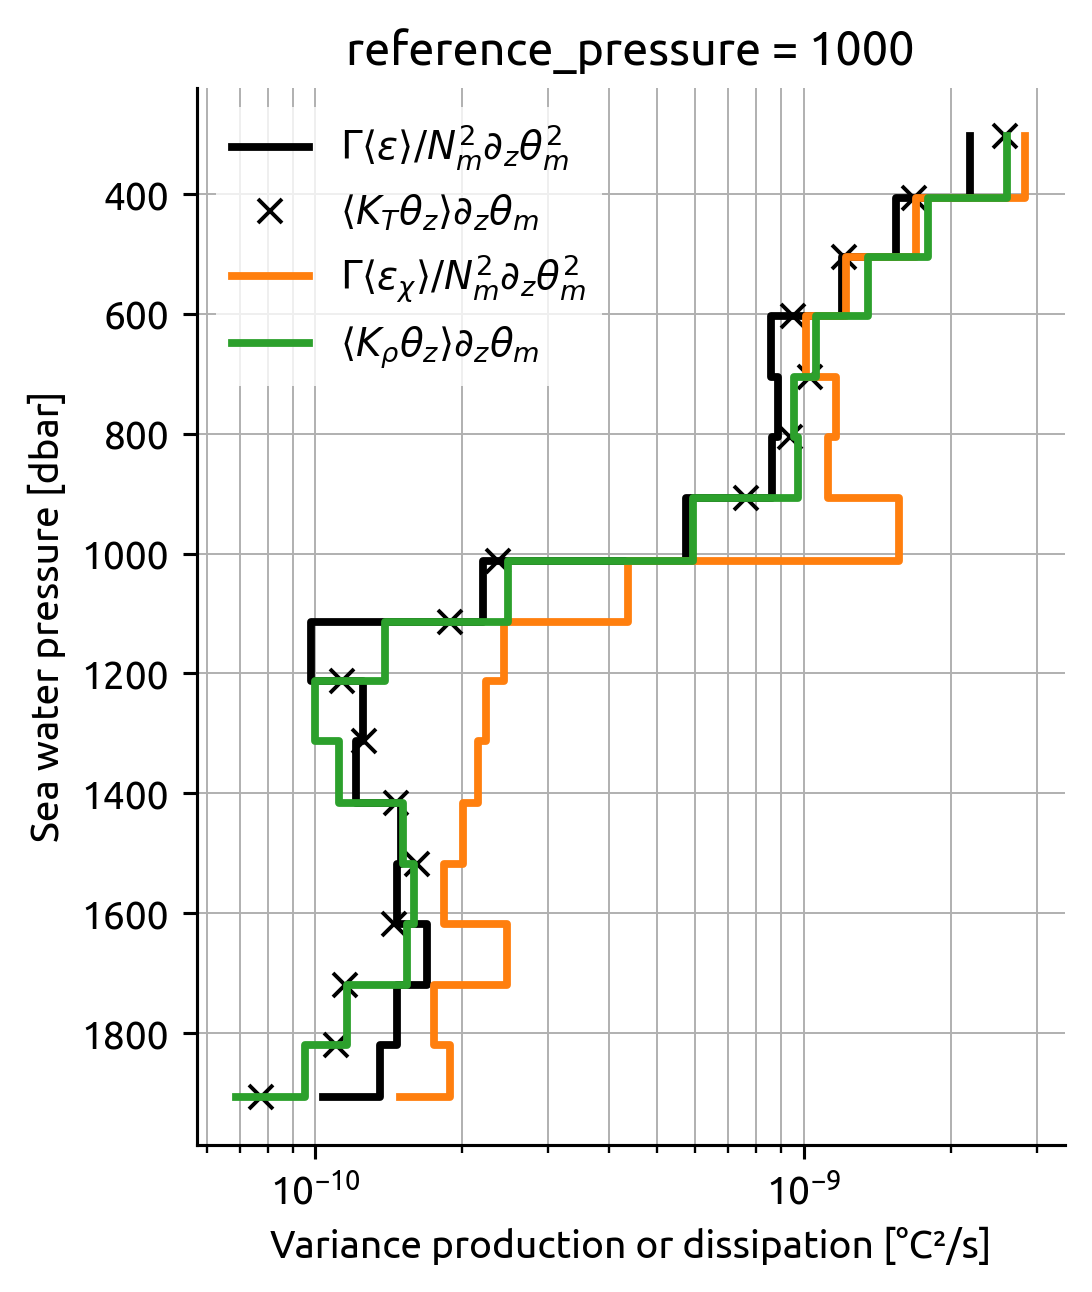

In [39]:
(chidens.Krho_m * chidens.dTdz_m ** 2).cf.plot.step(
    color="k", lw=2, label="$Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$"
)

(chidens.KtTz * chidens.dTdz_m).cf.plot.step(
    color="k", marker="x", ls="none", label="$⟨K_T θ_z⟩ ∂_zθ_m$"
)

(0.2 * chidens.eps_chi / chidens.N2_m * chidens.dTdz_m ** 2).cf.plot.step(
    color="C1", lw=2, label="$Γ ⟨ε_χ⟩/N_m^2  ∂_zθ_m^2$"
)

(chidens.KrhoTz * chidens.dTdz_m).cf.plot.step(
    lw=2, label="$⟨K_ρ θ_z⟩  ∂_zθ_m$", color="C2"
)

plt.grid(True, which="both", lw=0.5)

plt.legend()
plt.xscale("log")
plt.xlabel("Variance production or dissipation [°C²/s]")
plt.gcf().set_size_inches((4, 5))

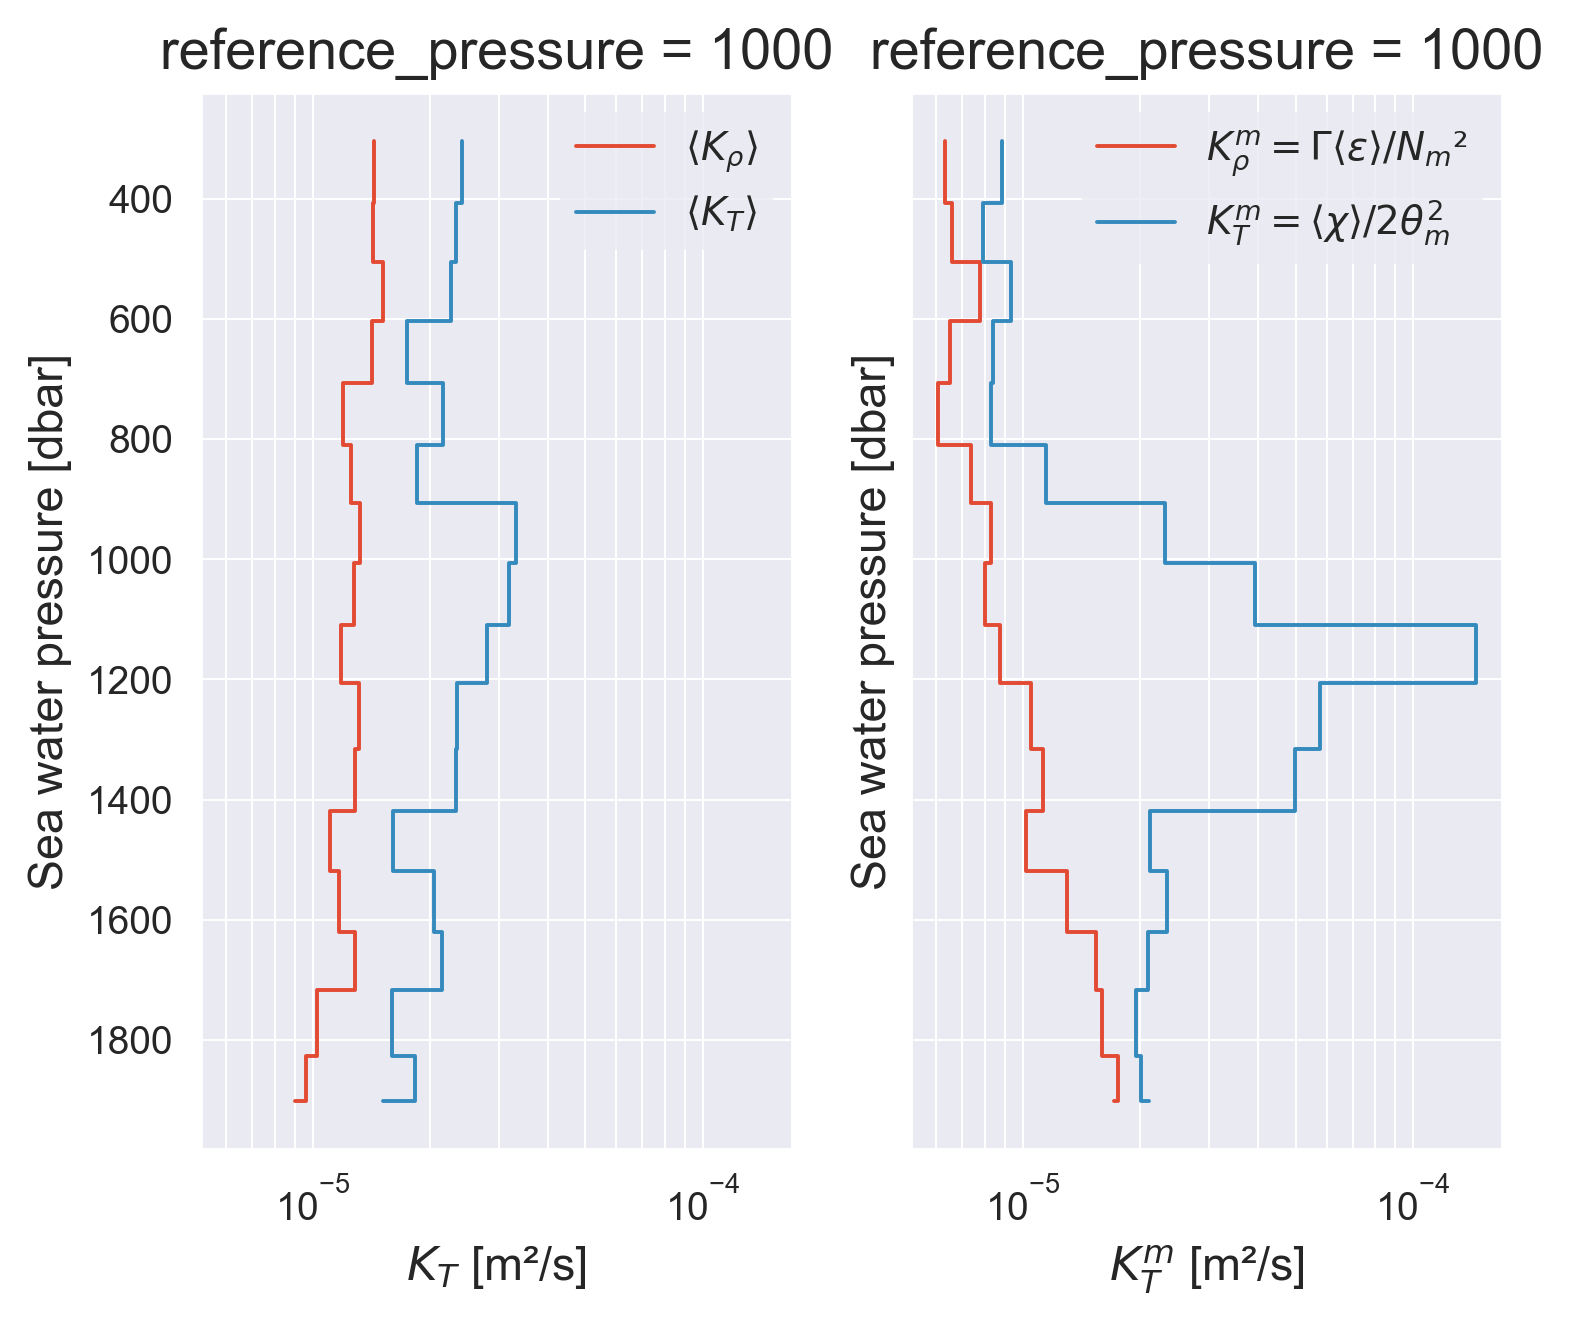

In [674]:
f, ax = plt.subplots(1, 2, sharey=True, sharex=True)
micro.Krho.cf.plot.step(y="pres", xscale="log", ax=ax[0])
micro.Kt.cf.plot.step(y="pres", ax=ax[0])
micro.Krho_m.cf.plot.step(y="pres", ax=ax[1])
micro.Kt_m.cf.plot.step(y="pres", ax=ax[1])
ax[0].legend(["$⟨K_ρ⟩$", "$⟨K_T⟩$"])
ax[1].legend(["$K_ρ^m = Γ ⟨ε⟩/N_m²$", "$K_T^m = ⟨χ⟩/2θ_m^2$"])
[aa.grid(True, which="both", lw=0.5) for aa in ax]
plt.gcf().set_size_inches((6, 5))

## Todo:

1. [ ] refactor finestructure + NATRE stuff to its own notebook.


See sensitivity to using
1. [x] $⟨K_ρ θ_z⟩ θ_z^m = ⟨Γε/N² θ_z⟩ θ_z^m$
2. [x] Use $Γ ⟨ε_χ⟩/N_m^2$
3. [x] Using neutral density bins instead of $σ_{1}$
4. [x] $T_z$ filtering